In [1]:
# pip install gurobipy

In [2]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import *

import numpy as np
import pandas as pd
from IPython.display import display

import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tabulate import tabulate
import statistics as st
import random
import copy

import seaborn as sns

import time

In [3]:
def SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      #::Int64,
    exposed_population,          #::Int64,
    recovered_population,       #::Int64,
    infected_population,         #::Int64,
    cured_population,            #::Int64,
    deaded_population,           #::Int64,
        
# (1.2) contact rate & proportion
    contact_rate,                #::Vector,
    contact_rate_proportion,     #::Vector,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              #::Vector,
    exposed_to_infected_rate,    #::Vector,
    recovery_rate_for_exposed,   #::Vector,
    cured_rate_for_infected,     #::Vector,
    death_rate,                  #::Vector,
    sensitivity_proportion,      #::Vector,
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    
    
### (2) Define parameters for all group divisions based on activity and sensitivity
    sensitivity_number = len(sensitivity_proportion)
    activity_number = len(contact_rate_proportion)
    N_0 = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    division_number = sensitivity_number * activity_number     # number of divisions
    c = np.zeros(division_number)          # contact rate
    p = np.zeros(division_number)          # proportion
    lambdas = np.zeros(division_number)          # lamda, Infection rate
    gammas = np.zeros(division_number)          # gamma, Exposed to infected rate
    sigma_Es = np.zeros(division_number)          # sigma_E, Recovery rate for exposed
    sigma_Is = np.zeros(division_number)          # sigma_I, Cured rate for infected
    deltas = np.zeros(division_number)          # delta, death rate (case fatality rate)

    for j in range(0,activity_number):
        for i in range(0,sensitivity_number):
            c[(j)*sensitivity_number+i] = contact_rate[j]
            p[(j)*sensitivity_number+i] = contact_rate_proportion[j]*sensitivity_proportion[i]
            lambdas[(j)*sensitivity_number+i] = infection_rate[i]
            gammas[(j)*sensitivity_number+i] = exposed_to_infected_rate[i]
            sigma_Es[(j)*sensitivity_number+i] = recovery_rate_for_exposed[i]
            sigma_Is[(j)*sensitivity_number+i] = cured_rate_for_infected[i]
            deltas[(j)*sensitivity_number+i] = death_rate[i]
        # end for i
    # end for j

# (2.1) Show all the parameters for each division (not be printed out)
    Sensitivity_Matrix = np.zeros((7, division_number))
    Sensitivity_Matrix[0] = p        ; Sensitivity_Matrix[1] = c      
    Sensitivity_Matrix[2] = lambdas  ; Sensitivity_Matrix[3] = gammas  
    Sensitivity_Matrix[4] = sigma_Es ; Sensitivity_Matrix[5] = sigma_Is
    Sensitivity_Matrix[6] = deltas 
    Sensitivity_Matrix_df = pd.DataFrame(Sensitivity_Matrix.T)
    colnames = ["Proportion","Contact rate","Infection rate","Exposed to infected","Recovery rate","Cured rate","Death rate"]
    Sensitivity_Matrix_df.columns = colnames
    
### (3) Prepare to record population in each division for all time
    S = np.zeros((terminal_time+1, division_number))
    dS = np.zeros((terminal_time+1, division_number))
    E = np.zeros((terminal_time+1, division_number))
    R = np.zeros((terminal_time+1, division_number)) 
    I = np.zeros((terminal_time+1, division_number))
    C = np.zeros((terminal_time+1, division_number))
    D = np.zeros((terminal_time+1, division_number))
    dD = np.zeros((terminal_time, division_number)) 
    N = np.zeros((terminal_time+1, division_number))
    V = np.zeros((terminal_time+1, division_number))         # V records vaccinated population of each period 
    Immunized = np.zeros((terminal_time+1, division_number)) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0,:] = p * susceptible_population    
    E[0,:] = p * exposed_population    
    R[0,:] = p * recovered_population
    I[0,:] = p * infected_population
    C[0,:] = p * cured_population
    D[0,:] = p * deaded_population
    N[0,:] = p * N_0

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = N_0/vaccine_coverage_time
    
    for t in range(1,terminal_time+1):  # 1 to terminal_time
    
# (5.1) Vaccination strategy (decide how many people vaccinated in each division)
        
        v = vaccination_strategy(t, 
                                 contact_rate, # this is the rawe input contact rate
                                 c, # this one is a renewed term for each division, others are raw input
                                 infection_rate,
                                 exposed_to_infected_rate,
                                 gammas, # this one is a renewed term for each division, others are raw input
                                 recovery_rate_for_exposed,
                                 cured_rate_for_infected,
                                 death_rate,
                                 vaccine_max, 
                                 S[t-1], E[t-1], R[t-1], I[t-1], N[t-1], Immunized[t-1], 
                                 total_time_for_greedy)
        
        V[t-1] = v                        # Record vaccinated people in period t
        Immunized[t] = sum(V)     # Record total vaccinated people till time t

# (5.1.1) Determine vaccinated proportion for each division among S, E, R states, in case we have 0/(0 + 0 + 0)
    
        vaccinated_proportion_in_S = np.zeros(division_number)
        vaccinated_proportion_in_E = np.zeros(division_number)
        vaccinated_proportion_in_R = np.zeros(division_number)
        
        for k in range(0,division_number): 
            if S[t-1,k] == 0:
                vaccinated_proportion_in_S[k] = 0
            else:
                vaccinated_proportion_in_S[k] = S[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if E[t-1,k] == 0:
                vaccinated_proportion_in_E[k] = 0
            else:
                vaccinated_proportion_in_E[k] = E[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if R[t-1,k] == 0:
                vaccinated_proportion_in_R[k] = 0
            else:
                vaccinated_proportion_in_R[k] = R[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
        # end for k
    
                    
# (5.2) determine delta S for each division k
  
        for k in range(0,division_number): 
            if S[t-1,k] == 0:   # no more S people, dS will be 0.
                dS[t-1,k] = 0
            else:
                source = sum(c*(E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E)) # population contacted by exposed people
                dS[t-1,k] = min(lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
            # end if
        # end for k
        
# (5.3) SEIR change: S, E, R, I, C
    
        S[t] = S[t-1] - dS[t-1]                                    - vaccine_efficacy * v * vaccinated_proportion_in_S
        E[t] = E[t-1] + dS[t-1] - sigma_Es*E[t-1] - gammas*E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E
        R[t] = R[t-1]           + sigma_Es*E[t-1]                  - vaccine_efficacy * v * vaccinated_proportion_in_R             
        I[t] = I[t-1]                              + gammas*E[t-1] - sigma_Is*I[t-1] - deltas*I[t-1]
        C[t] = C[t-1]                                              + sigma_Is*I[t-1]
        
        for k in range(0,division_number):        # in case the population decreases to negative
            S[t,k] = max(S[t,k], 0)   
            E[t,k] = max(E[t,k], 0)
            R[t,k] = max(R[t,k], 0)
        # end for k

# (5.4) Death occured in t-th period
    
        for k in range(0,division_number): 
            dD[t-1,k] = min(deltas[k]*I[t-1,k], N[t-1,k])
        # end for k
                                        
# (5.5) SEIR change: D, N  
        
        D[t] = D[t-1] + dD[t-1]
        N[t] = N[t-1] - dD[t-1]

    # end for t

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

In [4]:
def SEIR_simulation_greedy(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      #::Int64,
    exposed_population,          #::Int64,
    recovered_population,       #::Int64,
    infected_population,         #::Int64,
    cured_population,            #::Int64,
    deaded_population,           #::Int64,
        
# (1.2) contact rate & proportion
    contact_rate,                #::Vector,
    contact_rate_proportion,     #::Vector,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              #::Vector,
    exposed_to_infected_rate,    #::Vector,
    recovery_rate_for_exposed,   #::Vector,
    cured_rate_for_infected,     #::Vector,
    death_rate,                  #::Vector,
    sensitivity_proportion,      #::Vector,
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    
    
### (2) Define parameters for all group divisions based on activity and sensitivity
    sensitivity_number = len(sensitivity_proportion)
    activity_number = len(contact_rate_proportion)
    N_0 = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    division_number = sensitivity_number * activity_number     # number of divisions
    c = np.zeros(division_number)          # contact rate
    p = np.zeros(division_number)          # proportion
    lambdas = np.zeros(division_number)          # lamda, Infection rate
    gammas = np.zeros(division_number)          # gamma, Exposed to infected rate
    sigma_Es = np.zeros(division_number)          # sigma_E, Recovery rate for exposed
    sigma_Is = np.zeros(division_number)          # sigma_I, Cured rate for infected
    deltas = np.zeros(division_number)          # delta, death rate (case fatality rate)

    for j in range(0,activity_number):
        for i in range(0,sensitivity_number):
            c[(j)*sensitivity_number+i] = contact_rate[j]
            p[(j)*sensitivity_number+i] = contact_rate_proportion[j]*sensitivity_proportion[i]
            lambdas[(j)*sensitivity_number+i] = infection_rate[i]
            gammas[(j)*sensitivity_number+i] = exposed_to_infected_rate[i]
            sigma_Es[(j)*sensitivity_number+i] = recovery_rate_for_exposed[i]
            sigma_Is[(j)*sensitivity_number+i] = cured_rate_for_infected[i]
            deltas[(j)*sensitivity_number+i] = death_rate[i]
        # end for i
    # end for j

# (2.1) Show all the parameters for each division (not be printed out)
    Sensitivity_Matrix = np.zeros((7, division_number))
    Sensitivity_Matrix[0] = p        ; Sensitivity_Matrix[1] = c      
    Sensitivity_Matrix[2] = lambdas  ; Sensitivity_Matrix[3] = gammas  
    Sensitivity_Matrix[4] = sigma_Es ; Sensitivity_Matrix[5] = sigma_Is
    Sensitivity_Matrix[6] = deltas 
    Sensitivity_Matrix_df = pd.DataFrame(Sensitivity_Matrix.T)
    colnames = ["Proportion","Contact rate","Infection rate","Exposed to infected","Recovery rate","Cured rate","Death rate"]
    Sensitivity_Matrix_df.columns = colnames
    
### (3) Prepare to record population in each division for all time
    S = np.zeros((terminal_time+1, division_number))
    dS = np.zeros((terminal_time+1, division_number))
    E = np.zeros((terminal_time+1, division_number))
    R = np.zeros((terminal_time+1, division_number)) 
    I = np.zeros((terminal_time+1, division_number))
    C = np.zeros((terminal_time+1, division_number))
    D = np.zeros((terminal_time+1, division_number))
    dD = np.zeros((terminal_time, division_number)) 
    N = np.zeros((terminal_time+1, division_number))
    V = np.zeros((terminal_time+1, division_number))         # V records vaccinated population of each period 
    Immunized = np.zeros((terminal_time+1, division_number)) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0,:] = p * susceptible_population    
    E[0,:] = p * exposed_population    
    R[0,:] = p * recovered_population
    I[0,:] = p * infected_population
    C[0,:] = p * cured_population
    D[0,:] = p * deaded_population 
    N[0,:] = p * N_0

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = N_0/vaccine_coverage_time
    
    for t_index in range(1,terminal_time+1):  # 1 to terminal_time
    
# (5.1) Vaccination strategy (decide how many people vaccinated in each division)
        
        v = vaccination_strategy(t_index, 
                                 contact_rate, # this is the rawe input contact rate
                                 c, # this one is a renewed term for each division, others are raw input
                                 infection_rate,
                                 exposed_to_infected_rate,
                                 gammas, # this one is a renewed term for each division, others are raw input
                                 recovery_rate_for_exposed,
                                 cured_rate_for_infected,
                                 death_rate,
                                 vaccine_max, 
                                 S[t_index-1], E[t_index-1], R[t_index-1], I[t_index-1], C[t_index-1], D[t_index-1], Immunized[t_index-1], 
                                 total_time_for_greedy)
        
        #V[t_index-1] = v[0]                        # Record vaccinated people in period t
        S[t_index] = v[1]
        E[t_index] = v[2]
        R[t_index] = v[3]
        I[t_index] = v[4]
        C[t_index] = v[5]
        D[t_index] = v[6]
        Immunized[t_index] = v[7]

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

Change the contact rate of high sensitivity only

In [5]:
def SEIR_simulation_partial_change_c(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      #::Int64,
    exposed_population,          #::Int64,
    recovered_population,       #::Int64,
    infected_population,         #::Int64,
    cured_population,            #::Int64,
    deaded_population,           #::Int64,
        
# (1.2) contact rate & proportion
    contact_rate,                #::Vector,
    contact_rate_proportion,     #::Vector,   
    contact_change_factor,      
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              #::Vector,
    exposed_to_infected_rate,    #::Vector,
    recovery_rate_for_exposed,   #::Vector,
    cured_rate_for_infected,     #::Vector,
    death_rate,                  #::Vector,
    sensitivity_proportion,      #::Vector,
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    
    
### (2) Define parameters for all group divisions based on activity and sensitivity
    sensitivity_number = len(sensitivity_proportion)
    activity_number = len(contact_rate_proportion)
    N_0 = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    division_number = sensitivity_number * activity_number     # number of divisions
    c = np.zeros(division_number)          # contact rate
    p = np.zeros(division_number)          # proportion
    lambdas = np.zeros(division_number)          # lamda, Infection rate
    gammas = np.zeros(division_number)          # gamma, Exposed to infected rate
    sigma_Es = np.zeros(division_number)          # sigma_E, Recovery rate for exposed
    sigma_Is = np.zeros(division_number)          # sigma_I, Cured rate for infected
    deltas = np.zeros(division_number)          # delta, death rate (case fatality rate)

    for j in range(0,activity_number):
        for i in range(0,sensitivity_number):
            c[(j)*sensitivity_number+i] = contact_rate[j]
            p[(j)*sensitivity_number+i] = contact_rate_proportion[j]*sensitivity_proportion[i]
            lambdas[(j)*sensitivity_number+i] = infection_rate[i]
            gammas[(j)*sensitivity_number+i] = exposed_to_infected_rate[i]
            sigma_Es[(j)*sensitivity_number+i] = recovery_rate_for_exposed[i]
            sigma_Is[(j)*sensitivity_number+i] = cured_rate_for_infected[i]
            deltas[(j)*sensitivity_number+i] = death_rate[i]
        # end for i
    # end for j
    
    # change the contact rate for high sensitivity
#     c[0] = c[0]/2 ; c[2] = c[2]/2
    for index in range(0,division_number):
        if gammas[index] == exposed_to_infected_rate[0]:
            c[index] = c[index]/contact_change_factor

# (2.1) Show all the parameters for each division (not be printed out)
    Sensitivity_Matrix = np.zeros((7, division_number))
    Sensitivity_Matrix[0] = p        ; Sensitivity_Matrix[1] = c      
    Sensitivity_Matrix[2] = lambdas  ; Sensitivity_Matrix[3] = gammas  
    Sensitivity_Matrix[4] = sigma_Es ; Sensitivity_Matrix[5] = sigma_Is
    Sensitivity_Matrix[6] = deltas 
    Sensitivity_Matrix_df = pd.DataFrame(Sensitivity_Matrix.T)
    colnames = ["Proportion","Contact rate","Infection rate","Exposed to infected","Recovery rate","Cured rate","Death rate"]
    Sensitivity_Matrix_df.columns = colnames
    
### (3) Prepare to record population in each division for all time
    S = np.zeros((terminal_time+1, division_number))
    dS = np.zeros((terminal_time+1, division_number))
    E = np.zeros((terminal_time+1, division_number))
    R = np.zeros((terminal_time+1, division_number)) 
    I = np.zeros((terminal_time+1, division_number))
    C = np.zeros((terminal_time+1, division_number))
    D = np.zeros((terminal_time+1, division_number))
    dD = np.zeros((terminal_time, division_number)) 
    N = np.zeros((terminal_time+1, division_number))
    V = np.zeros((terminal_time+1, division_number))         # V records vaccinated population of each period 
    Immunized = np.zeros((terminal_time+1, division_number)) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0,:] = p * susceptible_population    
    E[0,:] = p * exposed_population    
    R[0,:] = p * recovered_population
    I[0,:] = p * infected_population
    C[0,:] = p * cured_population
    D[0,:] = p * deaded_population
    N[0,:] = p * N_0

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = N_0/vaccine_coverage_time
    
    for t in range(1,terminal_time+1):  # 1 to terminal_time
    
# (5.1) Vaccination strategy (decide how many people vaccinated in each division)
        
        v = vaccination_strategy(t, 
                                 contact_rate, # this is the rawe input contact rate
                                 c, # this one is a renewed term for each division, others are raw input
                                 infection_rate,
                                 exposed_to_infected_rate,
                                 gammas, # this one is a renewed term for each division, others are raw input
                                 recovery_rate_for_exposed,
                                 cured_rate_for_infected,
                                 death_rate,
                                 vaccine_max, 
                                 S[t-1], E[t-1], R[t-1], I[t-1], N[t-1], Immunized[t-1], 
                                 total_time_for_greedy)
        
        V[t-1] = v                        # Record vaccinated people in period t
        Immunized[t] = sum(V)     # Record total vaccinated people till time t

# (5.1.1) Determine vaccinated proportion for each division among S, E, R states, in case we have 0/(0 + 0 + 0)
    
        vaccinated_proportion_in_S = np.zeros(division_number)
        vaccinated_proportion_in_E = np.zeros(division_number)
        vaccinated_proportion_in_R = np.zeros(division_number)
        
        for k in range(0,division_number): 
            if S[t-1,k] == 0:
                vaccinated_proportion_in_S[k] = 0
            else:
                vaccinated_proportion_in_S[k] = S[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if E[t-1,k] == 0:
                vaccinated_proportion_in_E[k] = 0
            else:
                vaccinated_proportion_in_E[k] = E[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if R[t-1,k] == 0:
                vaccinated_proportion_in_R[k] = 0
            else:
                vaccinated_proportion_in_R[k] = R[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
        # end for k
    
                    
# (5.2) determine delta S for each division k
  
        for k in range(0,division_number): 
            if S[t-1,k] == 0:   # no more S people, dS will be 0.
                dS[t-1,k] = 0
            else:
                source = sum(c*(E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E)) # population contacted by exposed people
                dS[t-1,k] = min(lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
            # end if
        # end for k
        
# (5.3) SEIR change: S, E, R, I, C
    
        S[t] = S[t-1] - dS[t-1]                                    - vaccine_efficacy * v * vaccinated_proportion_in_S
        E[t] = E[t-1] + dS[t-1] - sigma_Es*E[t-1] - gammas*E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E
        R[t] = R[t-1]           + sigma_Es*E[t-1]                  - vaccine_efficacy * v * vaccinated_proportion_in_R             
        I[t] = I[t-1]                              + gammas*E[t-1] - sigma_Is*I[t-1] - deltas*I[t-1]
        C[t] = C[t-1]                                              + sigma_Is*I[t-1]
        
        for k in range(0,division_number):        # in case the population decreases to negative
            S[t,k] = max(S[t,k], 0)   
            E[t,k] = max(E[t,k], 0)
            R[t,k] = max(R[t,k], 0)
        # end for k

# (5.4) Death occured in t-th period
    
        for k in range(0,division_number): 
            dD[t-1,k] = min(deltas[k]*I[t-1,k], N[t-1,k])
        # end for k
                                        
# (5.5) SEIR change: D, N  
        
        D[t] = D[t-1] + dD[t-1]
        N[t] = N[t-1] - dD[t-1]

    # end for t

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

Change the sensitivity of high contact rate only

In [6]:
def SEIR_simulation_partial_change_s(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      #::Int64,
    exposed_population,          #::Int64,
    recovered_population,       #::Int64,
    infected_population,         #::Int64,
    cured_population,            #::Int64,
    deaded_population,           #::Int64,
        
# (1.2) contact rate & proportion
    contact_rate,                #::Vector,
    contact_rate_proportion,     #::Vector,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              #::Vector,
    exposed_to_infected_rate,    #::Vector,
    recovery_rate_for_exposed,   #::Vector,
    cured_rate_for_infected,     #::Vector,
    death_rate,                  #::Vector,
    sensitivity_proportion,      #::Vector,
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    
    
### (2) Define parameters for all group divisions based on activity and sensitivity
    sensitivity_number = len(sensitivity_proportion)
    activity_number = len(contact_rate_proportion)
    N_0 = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    division_number = sensitivity_number * activity_number     # number of divisions
    c = np.zeros(division_number)          # contact rate
    p = np.zeros(division_number)          # proportion
    lambdas = np.zeros(division_number)          # lamda, Infection rate
    gammas = np.zeros(division_number)          # gamma, Exposed to infected rate
    sigma_Es = np.zeros(division_number)          # sigma_E, Recovery rate for exposed
    sigma_Is = np.zeros(division_number)          # sigma_I, Cured rate for infected
    deltas = np.zeros(division_number)          # delta, death rate (case fatality rate)

    for j in range(0,activity_number):
        for i in range(0,sensitivity_number):
            c[(j)*sensitivity_number+i] = contact_rate[j]
            p[(j)*sensitivity_number+i] = contact_rate_proportion[j]*sensitivity_proportion[i]
            lambdas[(j)*sensitivity_number+i] = infection_rate[i]
            gammas[(j)*sensitivity_number+i] = exposed_to_infected_rate[i]
            sigma_Es[(j)*sensitivity_number+i] = recovery_rate_for_exposed[i]
            sigma_Is[(j)*sensitivity_number+i] = cured_rate_for_infected[i]
            deltas[(j)*sensitivity_number+i] = death_rate[i]
        # end for i
    # end for j
    
    # change the sensitivity for high contact rate
    for index in range(0,division_number):
        if c[index] == contact_rate[0]:
            lambdas[index] = lambdas[index]/2
            gammas[index] = gammas[index]/2
            sigma_Es[index] = sigma_Es[index]/2
            sigma_Is[index] = sigma_Is[index]/2
#             deltas[index] = deltas[index]/2

# (2.1) Show all the parameters for each division (not be printed out)
    Sensitivity_Matrix = np.zeros((7, division_number))
    Sensitivity_Matrix[0] = p        ; Sensitivity_Matrix[1] = c      
    Sensitivity_Matrix[2] = lambdas  ; Sensitivity_Matrix[3] = gammas  
    Sensitivity_Matrix[4] = sigma_Es ; Sensitivity_Matrix[5] = sigma_Is
    Sensitivity_Matrix[6] = deltas 
    Sensitivity_Matrix_df = pd.DataFrame(Sensitivity_Matrix.T)
    colnames = ["Proportion","Contact rate","Infection rate","Exposed to infected","Recovery rate","Cured rate","Death rate"]
    Sensitivity_Matrix_df.columns = colnames
    
### (3) Prepare to record population in each division for all time
    S = np.zeros((terminal_time+1, division_number))
    dS = np.zeros((terminal_time+1, division_number))
    E = np.zeros((terminal_time+1, division_number))
    R = np.zeros((terminal_time+1, division_number)) 
    I = np.zeros((terminal_time+1, division_number))
    C = np.zeros((terminal_time+1, division_number))
    D = np.zeros((terminal_time+1, division_number))
    dD = np.zeros((terminal_time, division_number)) 
    N = np.zeros((terminal_time+1, division_number))
    V = np.zeros((terminal_time+1, division_number))         # V records vaccinated population of each period 
    Immunized = np.zeros((terminal_time+1, division_number)) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0,:] = p * susceptible_population    
    E[0,:] = p * exposed_population    
    R[0,:] = p * recovered_population
    I[0,:] = p * infected_population
    C[0,:] = p * cured_population
    D[0,:] = p * deaded_population
    N[0,:] = p * N_0

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = N_0/vaccine_coverage_time
    
    for t in range(1,terminal_time+1):  # 1 to terminal_time
    
# (5.1) Vaccination strategy (decide how many people vaccinated in each division)
        
        v = vaccination_strategy(t, 
                                 contact_rate, # this is the rawe input contact rate
                                 c, # this one is a renewed term for each division, others are raw input
                                 infection_rate,
                                 exposed_to_infected_rate,
                                 gammas, # this one is a renewed term for each division, others are raw input
                                 recovery_rate_for_exposed,
                                 cured_rate_for_infected,
                                 death_rate,
                                 vaccine_max, 
                                 S[t-1], E[t-1], R[t-1], I[t-1], N[t-1], Immunized[t-1], 
                                 total_time_for_greedy)
        
        V[t-1] = v                        # Record vaccinated people in period t
        Immunized[t] = sum(V)     # Record total vaccinated people till time t

# (5.1.1) Determine vaccinated proportion for each division among S, E, R states, in case we have 0/(0 + 0 + 0)
    
        vaccinated_proportion_in_S = np.zeros(division_number)
        vaccinated_proportion_in_E = np.zeros(division_number)
        vaccinated_proportion_in_R = np.zeros(division_number)
        
        for k in range(0,division_number): 
            if S[t-1,k] == 0:
                vaccinated_proportion_in_S[k] = 0
            else:
                vaccinated_proportion_in_S[k] = S[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if E[t-1,k] == 0:
                vaccinated_proportion_in_E[k] = 0
            else:
                vaccinated_proportion_in_E[k] = E[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if R[t-1,k] == 0:
                vaccinated_proportion_in_R[k] = 0
            else:
                vaccinated_proportion_in_R[k] = R[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
        # end for k
    
                    
# (5.2) determine delta S for each division k
  
        for k in range(0,division_number): 
            if S[t-1,k] == 0:   # no more S people, dS will be 0.
                dS[t-1,k] = 0
            else:
                source = sum(c*(E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E)) # population contacted by exposed people
                dS[t-1,k] = min(lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
            # end if
        # end for k
        
# (5.3) SEIR change: S, E, R, I, C
    
        S[t] = S[t-1] - dS[t-1]                                    - vaccine_efficacy * v * vaccinated_proportion_in_S
        E[t] = E[t-1] + dS[t-1] - sigma_Es*E[t-1] - gammas*E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E
        R[t] = R[t-1]           + sigma_Es*E[t-1]                  - vaccine_efficacy * v * vaccinated_proportion_in_R             
        I[t] = I[t-1]                              + gammas*E[t-1] - sigma_Is*I[t-1] - deltas*I[t-1]
        C[t] = C[t-1]                                              + sigma_Is*I[t-1]
        
        for k in range(0,division_number):        # in case the population decreases to negative
            S[t,k] = max(S[t,k], 0)   
            E[t,k] = max(E[t,k], 0)
            R[t,k] = max(R[t,k], 0)
        # end for k

# (5.4) Death occured in t-th period
    
        for k in range(0,division_number): 
            dD[t-1,k] = min(deltas[k]*I[t-1,k], N[t-1,k])
        # end for k
                                        
# (5.5) SEIR change: D, N  
        
        D[t] = D[t-1] + dD[t-1]
        N[t] = N[t-1] - dD[t-1]

    # end for t

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

# III. Vaccination Strategies

Input population arranged in the following order:

(1) high contact, high sensitivity;
(2) high contact, low sensitivity;
(3) low contact, high sensitivity;
(4) low contact, low sensitivity;

3.1 No vaccination

In [7]:
def no_vaccination(t_th_period, 
                   unadjusted_contact,
                   contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                   E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, N_t, V_t, 
                        T_max_for_greedy):
    return(np.zeros(len(contact)))
# end def

3.2 Proposed vaccination - distribute vaccine based on division's priority, which is "contact rate * sensitivity".

In [8]:
def proposed_vaccination(t_th_period, 
                         unadjusted_contact,
                         contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                         E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, N_t, V_t, 
                        T_max_for_greedy):
# initialization before allocating vaccine
    v = np.zeros(len(contact))
    
# defines vaccination priority for each division    
    dividsion_priority = np.zeros(len(contact))  
    for k in range(0,len(contact)):
        dividsion_priority[k] = contact[k] * E_to_I_rate[k]
    # end for k
    
# allocate vaccine based on priority
    for k in range(0,len(contact)):
        order_list = np.argsort(dividsion_priority).tolist() # which group has the lowest to highest priority
        order_list.reverse()                                 # reverse the order to highest to lowest priority
        chosen_group = order_list[k]
        if S_t[chosen_group] + E_t[chosen_group] > 0:
            v[chosen_group] = min((S_t[chosen_group] + E_t[chosen_group] + R_t[chosen_group]), max_vaccine_amount - sum(v)) 
        # end if
     # end for k
    
    return(v)
# end def

3.3 Contact rate based vaccination (distribute vaccine in each division only based on contact rate)

In [9]:
def contact_rate_based_vaccination(t_th_period, 
                                   unadjusted_contact,
                                   contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, N_t, V_t, 
                        T_max_for_greedy):
# initialization before allocating vaccine
    v = np.zeros(len(contact))
    contact_no_duplicate = [i for n, i in enumerate(contact) if i not in contact[:n]]
    E_to_I_rate_no_duplicate = [i for n, i in enumerate(E_to_I_rate) if i not in E_to_I_rate[:n]]
    
# allocate vaccine based on contact rate, same contact rate, randomize    
    if max_vaccine_amount < sum(S_t+E_t+R_t):  # vaccine cannot cover all
        m = 0
        while m < len(contact_no_duplicate):
            begin = m * len(E_to_I_rate_no_duplicate)
            end = m * len(E_to_I_rate_no_duplicate) + len(E_to_I_rate_no_duplicate)
            vac = 1
            vaccine_limit = max_vaccine_amount - sum(v)
            while vac <= min(vaccine_limit, sum(S_t[begin:end]+E_t[begin:end]+R_t[begin:end])) :
                #choosen_group = math.floor(np.random.uniform(begin,end))
                choosen_group = random.choices(population = range(begin,end),
                                               weights = ((S_t[begin:end]+E_t[begin:end]+R_t[begin:end])/sum(S_t[begin:end]+E_t[begin:end]+R_t[begin:end])).tolist(),
                                               k = 1)[0] # return a list, choose 1st element by [0]
                if v[choosen_group] < S_t[choosen_group] + E_t[choosen_group] + R_t[choosen_group]:
                    v[choosen_group] = v[choosen_group] + 1
                    vac = vac + 1
                # end if
            # end while
            m = m + 1
        # end while
    else: # vaccine can cover all                
        v = S_t + E_t + R_t
    # end if else    
    
    return(v)
# end def             

 Do not use! Not realistic 3.4 Uniform Vaccination - distribute vaccine in each division uniformly

In [10]:
# def uniform_vaccination(t_th_period, 
#                         unadjusted_contact,
#                         contact, 
#                         S_to_E_rate,
#                         unadjusted_E_to_I_rate.
#                         E_to_I_rate, 
#                         E_to_R_rate,
#                         I_to_C_rate,
#                         I_to_D_rate,
#                         max_vaccine_amount, 
#                         S_t, E_t, R_t, I_t, N_t, V_t, 
#                         T_max_for_greedy):
    
#     if max_vaccine_amount < sum(S_t+E_t+R_t):  # vaccine cannot cover all
#         v = np.zeros(len(contact))
#         i = 1
#         while i <= max_vaccine_amount:
#             # randome uniform to sample a person from one division
#             group_number = math.floor(np.random.uniform(0,len(contact)))
#             for k in range(0,len(contact)):
#                 if ((k == group_number) and (v[k] < S_t[k]+E_t[k]+R_t[k])):
#                     v[k] = v[k] + 1     # sampled division add one person vaccinated
#                     i = i + 1
#                 # end if
#             # end for k
#         # end while i
#     else:  # vaccine can cover all                
#         v = S_t + E_t + R_t
#     # end if else
    
#     return(v) # give the final vaccinated population in each division
# # end def

3.4 Random vaccination (distribute vaccine randomly, randomization based on proportion)

In [11]:
def random_vaccination(t_th_period, 
                       unadjusted_contact,
                       contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                       E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, N_t, V_t, 
                        T_max_for_greedy):
    
    if max_vaccine_amount < sum(S_t+E_t+R_t):  # vaccine cannot cover all
        v = np.zeros(len(contact))
        i = 1
        while i <= max_vaccine_amount:
            # randome sample a person from one division based on proportion 
            # group_number = sample(collect(1:length(contact)), Weights((S_t+E_t+R_t)/sum(S_t+E_t+R_t)) ) 
            group_number = random.choices(population = range(0,len(contact)),
                                          weights = ((S_t+E_t+R_t)/sum(S_t+E_t+R_t)).tolist(),
                                          k = 1) # return a list, choose 1st element by [0] below
            for k in range(0,len(contact)):
                if ((k == group_number[0]) and (v[k] < S_t[k]+E_t[k]+R_t[k])):
                    v[k] = v[k] + 1     # sampled division add one person vaccinated
                    i = i + 1
                # end if
            # end for k
        # end while
    else:  # vaccine can cover all                
        v = S_t + E_t + R_t
    # end if else    
    
    return(v)
# end def

3.5 Threhold approach - current protocal method ( based on age, related to sensitivity)

main contribution that we win the current method:
(1) vaccinate if sensitivity rate > some level;
(2) vaccinate if contract rate > some level;

High sensitivity (high risk) first, if same sensitivity, consider contact rate

In [12]:
def sen_1st_con_2nd_vaccination(t_th_period, 
                                unadjusted_contact,
                                contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, N_t, V_t, 
                        T_max_for_greedy):
# initialization before allocating vaccine
    v = np.zeros(len(contact))
    
# defines vaccination priority for each division    
    contact_no_duplicate = [i for n, i in enumerate(contact) if i not in contact[:n]]
    E_to_I_rate_no_duplicate = [i for n, i in enumerate(E_to_I_rate) if i not in E_to_I_rate[:n]]
    largest_priority = len(contact)
    
    dividsion_priority = np.zeros(len(contact))
    for m in range(0,len(contact_no_duplicate)):
        for k in range(0,len(E_to_I_rate_no_duplicate)):
            dividsion_priority[len(contact_no_duplicate) * k + m] = largest_priority
            largest_priority = largest_priority - 1
        # end for k
    # end for m
    
# allocate vaccine based on priority
    for k in range(0,len(contact)):
        order_list = np.argsort(dividsion_priority).tolist() # which group has the lowest to highest priority
        order_list.reverse()                                 # reverse the order to highest to lowest priority
        chosen_group = order_list[k]
        if S_t[chosen_group] + E_t[chosen_group] > 0:
            v[chosen_group] = min((S_t[chosen_group] + E_t[chosen_group] + R_t[chosen_group]), max_vaccine_amount - sum(v))  
        # end if
     # end for k
    
    return(v)
# end def

3.6 Contact rate 1st, sensitivity 2nd approach

In [13]:
def con_1st_sen_2nd_vaccination(t_th_period, 
                                unadjusted_contact,
                                contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, N_t, V_t, 
                        T_max_for_greedy):
# initialization before allocating vaccine
    v = np.zeros(len(contact))
    
# defines vaccination priority for each division   
    dividsion_priority = np.zeros(len(contact))  
    for k in range(0,len(contact)):
        dividsion_priority[k] = len(contact) - k
    # end for k
    
# allocate vaccine based on priority
    for k in range(0,len(contact)):
        order_list = np.argsort(dividsion_priority).tolist() # which group has the lowest to highest priority
        order_list.reverse()                                 # reverse the order to highest to lowest priority
        chosen_group = order_list[k]
        if S_t[chosen_group] + E_t[chosen_group] > 0:
            v[chosen_group] = min((S_t[chosen_group] + E_t[chosen_group] + R_t[chosen_group]), max_vaccine_amount - sum(v))  
        # end if
     # end for k
    
    return(v)
# end def

3.7 Greedy approach

In [80]:
def optimal_vaccination(t_th_period, 
                        unadjusted_contact,
                        contact, # this is for all divisions, others are raw input not adjusted for each division
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, # this is for all divisions, others are raw input not adjusted for each division
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, C_t, D_t, V_t, 
                        T_max_for_greedy):
    
    print("----------------------------------------------------------------------------------------------")
    print(t_th_period, "-th period STARTS")
    print("contact = ", unadjusted_contact)
    print("senstivity = ", unadjusted_E_to_I_rate)
    print("S = ", sum(S_t), S_t)
    print("E = ", sum(E_t), E_t)
    print("R = ", sum(R_t), R_t)
    print("I = ", sum(I_t), I_t)
    print("C = ", sum(C_t), C_t)
    print("D = ", sum(D_t), D_t)
    print("V = ", sum(V_t), V_t)
    print("----------------------------------------------------------------------------------------------")
    
    
#     for division in range(0,len(contact)):
#         if S_t[division] <= 0:
#             S_t[division] = 0
    
    SEIR3 = gp.Model("SEIR_contact_sensitivity")
    
    num_of_contact = len(unadjusted_contact)
    num_of_sensitivity = len(unadjusted_E_to_I_rate)
    num_divid = num_of_contact*num_of_sensitivity
    
    N_t = S_t + E_t + R_t + I_t + C_t + V_t
        
    M_big = sum(N_t) * T_max_for_greedy

    # Population of each state
    S_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T and T+1 variables in total
    E_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    R_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    I_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    C_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    D_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    N_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    V_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    dV_population = SEIR3.addVars(T_max_for_greedy, lb = 0, vtype = GRB.CONTINUOUS)
    dS_population = SEIR3.addVars(T_max_for_greedy, lb = 0, vtype = GRB.CONTINUOUS)

    # ij-th division
    S_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T and T+1 variables in total
    E_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    R_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    I_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    C_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    D_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    N_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    V_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    dV_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    dS_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS)


    E_k_population = SEIR3.addVars(T_max_for_greedy+1,num_of_contact, lb = 0, vtype = GRB.CONTINUOUS)

    # CONTINUOUS variables
    v_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T-1 and T variables in total
    un_v_S_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # eliminate the highest order term in (2): (1 - v_ij)*S_ij*E_ij
    vv_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # eliminate the highest order term in (5): (1 - v_ij)*(1 - v_ij)
    phi_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.BINARY) # for substitution
    
    obj3 = quicksum(dS_population[t] for t in range(0, T_max_for_greedy))
    SEIR3.setObjective(obj3, GRB.MINIMIZE)
    
    # initial population
    SEIR3.addConstr(S_population[0] == sum(S_t))
    SEIR3.addConstr(E_population[0] == sum(E_t))
    SEIR3.addConstr(R_population[0] == sum(R_t))
    SEIR3.addConstr(I_population[0] == sum(I_t))
    SEIR3.addConstr(C_population[0] == sum(C_t))
    SEIR3.addConstr(D_population[0] == sum(D_t))
    SEIR3.addConstr(N_population[0] == sum(N_t))
    SEIR3.addConstr(V_population[0] == sum(V_t))

    # initial population for each division
    for c_group in range(0,num_of_contact):
        for s_clan in range(0,num_of_sensitivity):
            SEIR3.addConstr(S_ij[0,c_group * num_of_contact + s_clan] == S_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(E_ij[0,c_group * num_of_contact + s_clan] == E_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(R_ij[0,c_group * num_of_contact + s_clan] == R_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(I_ij[0,c_group * num_of_contact + s_clan] == I_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(C_ij[0,c_group * num_of_contact + s_clan] == C_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(D_ij[0,c_group * num_of_contact + s_clan] == D_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(N_ij[0,c_group * num_of_contact + s_clan] == N_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(V_ij[0,c_group * num_of_contact + s_clan] == V_t[c_group * num_of_contact + s_clan])
        # end for
    # end for

    # total population = sum of population in each division
    for t in range(1,T_max_for_greedy+1):
        SEIR3.addConstr(S_population[t] == sum(S_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(E_population[t] == sum(E_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(R_population[t] == sum(R_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(I_population[t] == sum(I_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(C_population[t] == sum(C_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(D_population[t] == sum(D_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(V_population[t] == sum(V_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(N_population[t] == sum(N_ij[t,division] for division in range(0,num_divid)))
    
    # total population of dS and dV
    for t in range(0,T_max_for_greedy):
        SEIR3.addConstr(dS_population[t] == quicksum(dS_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(dV_population[t] == quicksum(dV_ij[t,division] for division in range(0,num_divid)))


    # source of spreading based on contact rate group
    for t in range(0, T_max_for_greedy):
        for c_group in range(0,num_of_contact):
            SEIR3.addConstr(E_k_population[t,c_group] == quicksum(E_ij[t,c_group * num_of_contact+s_clan] for s_clan in range(0,num_of_sensitivity)))

    # SEIR changes
    for c_group in range(0,num_of_contact):
        for s_clan in range(0,num_of_sensitivity):
            for t in range(0,T_max_for_greedy):
            # simplify terms
                ith = c_group * num_of_contact + s_clan
                source = sum(unadjusted_contact[group] * E_k_population[t,group] for group in range(0,num_of_contact))
            # substitution
                SEIR3.addConstr(un_v_S_ij[t,ith] == (1 - v_ij[t,ith]) * S_ij[t,ith])
                SEIR3.addConstr(vv_ij[t,ith] == (1 - v_ij[t,ith])*(1 - v_ij[t,ith]))
            # linearization of dS = min(A, B)
                SEIR3.addConstr(dS_ij[t,ith]*(N_population[t] - I_population[t]) <= un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source)
                SEIR3.addConstr(dS_ij[t,ith] <= un_v_S_ij[t,ith])
                SEIR3.addConstr(dS_ij[t,ith]*(N_population[t] - I_population[t]) >= un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source - M_big*(1 - phi_ij[t,ith])*(N_population[t] - I_population[t]))
                SEIR3.addConstr(dS_ij[t,ith] >= un_v_S_ij[t,ith] - M_big*phi_ij[t,ith])
                SEIR3.addConstr(M_big*phi_ij[t,ith]*(N_population[t] - I_population[t]) >= un_v_S_ij[t,ith]*(N_population[t] - I_population[t]) - un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source)
                SEIR3.addConstr(M_big*(1-phi_ij[t,ith])*(N_population[t] - I_population[t]) >= (un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source) - un_v_S_ij[t,ith]*(N_population[t] - I_population[t]))
            # other SEIR change
                SEIR3.addConstr(S_ij[t+1,ith] == (1 - v_ij[t,ith]) * S_ij[t,ith] - dS_ij[t,ith])
                SEIR3.addConstr(E_ij[t+1,ith] == (1 - v_ij[t,ith]) * (E_ij[t,ith] + dS_ij[t,ith] - E_to_R_rate[s_clan] * E_ij[t,ith] - E_to_I_rate[s_clan] * E_ij[t,ith]))
                SEIR3.addConstr(R_ij[t+1,ith] == (1 - v_ij[t,ith]) * R_ij[t,ith] + vv_ij[t,ith] * E_to_R_rate[s_clan] * E_ij[t,ith])                
                SEIR3.addConstr(I_ij[t+1,ith] == I_ij[t,ith] + (1 - v_ij[t,ith]) * E_to_I_rate[s_clan] * E_ij[t,ith] - I_to_C_rate[s_clan] * I_ij[t,ith] - I_to_D_rate[s_clan] * I_ij[t,ith]) 
                SEIR3.addConstr(C_ij[t+1,ith] == C_ij[t,ith] + I_to_C_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(D_ij[t+1,ith] == D_ij[t,ith] + I_to_D_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(N_ij[t+1,ith] == N_ij[t,ith] - I_to_D_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(dV_ij[t,ith] == v_ij[t,ith]*(S_ij[t,ith] + E_ij[t,ith] + R_ij[t,ith]))
                SEIR3.addConstr(V_ij[t+1,ith] == V_ij[t,ith] + dV_ij[t,ith])
                SEIR3.addConstr(v_ij[t,ith] <= 1)

        # vaccine limited amount
    for t in range(0,T_max_for_greedy):
        SEIR3.addConstr(quicksum(v_ij[t,division]*(S_ij[t,division] + E_ij[t,division] + R_ij[t,division]) for division in range(0,num_divid)) <= max_vaccine_amount)

    SEIR3.params.NonConvex = 2
    SEIR3.params.timelimit = 60.0
    SEIR3.Params.MIPGap = 0.001
    SEIR3.optimize()
    
    v = np.zeros(len(contact))
    S_population_for_next_round = np.zeros(len(contact))
    E_population_for_next_round = np.zeros(len(contact))
    R_population_for_next_round = np.zeros(len(contact))
    I_population_for_next_round = np.zeros(len(contact))
    C_population_for_next_round = np.zeros(len(contact))
    D_population_for_next_round = np.zeros(len(contact))
    V_population_for_next_round = np.zeros(len(contact))
        
    for division in range(0, num_divid):
        v[division] = dV_ij[0,division].X
        S_population_for_next_round[division] = S_ij[1,division].X
        E_population_for_next_round[division] = E_ij[1,division].X
        R_population_for_next_round[division] = R_ij[1,division].X
        I_population_for_next_round[division] = I_ij[1,division].X
        C_population_for_next_round[division] = C_ij[1,division].X
        D_population_for_next_round[division] = D_ij[1,division].X
        V_population_for_next_round[division] = V_ij[1,division].X
        
    print("----------------------------------------------------------------------------------------------")
    print(t_th_period, "-th period ends")
    print("contact = ", unadjusted_contact)
    print("senstivity = ", unadjusted_E_to_I_rate)
    print("S = ", S_population[1].X)
    print("E = ", E_population[1].X)
    print("R = ", R_population[1].X)
    print("I = ", I_population[1].X)
    print("C = ", C_population[1].X)
    print("D = ", D_population[1].X)
    print("V = ", V_population[1].X)
    print("v = ", v)
    print("----------------------------------------------------------------------------------------------")
    
    
        
    return(v, 
           S_population_for_next_round, 
           E_population_for_next_round, 
           R_population_for_next_round,
           I_population_for_next_round, 
           C_population_for_next_round, 
           D_population_for_next_round, 
           V_population_for_next_round)

Test the vaccination strategy code

In [16]:
# # no_vaccination, proposed_vaccination
# # contact_rate_based_vaccination, random_vaccination
# # sen_1st_con_2nd_vaccination, con_1st_sen_2nd_vaccination
# contact_rate_based_vaccination(0, 
#                     [25, 25, 15, 15],
#                     [1/7, 1/14, 1/7, 1/14],
#                     80,
#                     np.array([50, 20, 30, 10]), 
#                     np.array([0, 0, 0, 0]),
#                     np.array([0, 0, 0, 0]))

# IV. Output Result

4.1 Output - Population change line chart

In [17]:
def plot_population_change(susceptible_population,
                           exposed_population,
                           recovered_population,
                           infected_population,
                           cured_population,
                           deaded_population,
                           vaccinated_population,
                           immunized_population,
                           T_max):
    max_x = max( max(sum(susceptible_population.T)),
                 max(sum(exposed_population.T)),
                 max(sum(recovered_population.T)),
                 max(sum(infected_population.T)),
                 max(sum(cured_population.T)),
                 max(sum(deaded_population.T)),
                 max(sum(immunized_population.T)) )
    figure = plt.figure()
    plt.xlabel("Time (week)")
    plt.ylabel("Population")
    plt.xlim(0, T_max)
    plt.ylim(0, max_x)
    plt.plot(sum(susceptible_population.T), label="Susceptible", color="lime")
    plt.plot(sum(exposed_population.T), label="Exposed",     color="orange")
    plt.plot(sum(recovered_population.T), label="Recovered",   color="deepskyblue")
    plt.plot(sum(infected_population.T), label="Infected",    color="red")
    plt.plot(sum(cured_population.T), label="Cured",       color="royalblue")
    plt.plot(sum(deaded_population.T), label="Death",       color="black")
    plt.plot(sum(immunized_population.T), label="Vaccinated", color="hotpink")
    plt.legend()
    
# end def

4.2 Output - Population

In [18]:
def give_population_df(susceptible_population,
                    exposed_population,
                    recovered_population,
                    infected_population,
                    cured_population,
                    deaded_population,
                    vaccinated_population,
                    immunized_population,
                    T_max):
    Population_Matrix = np.zeros((7, T_max+1))
    Population_Matrix[0,:] = sum(susceptible_population.T)
    Population_Matrix[1,:] = sum(exposed_population.T)
    Population_Matrix[2,:] = sum(recovered_population.T)
    Population_Matrix[3,:] = sum(infected_population.T)
    Population_Matrix[4,:] = sum(cured_population.T)
    Population_Matrix[5,:] = sum(deaded_population.T)
    Population_Matrix[6,:] = sum(immunized_population.T)
    Population_Matrix_dataframe = pd.DataFrame(Population_Matrix.T)
    colnames = ["Susceptible","Exposed","Recovered","Infected","Cured","Death","Vaccinated"]
    Population_Matrix_dataframe.columns = colnames
    return(Population_Matrix_dataframe)
# end def

4.3 Output - Performance: Highest infection and when, total death, and total vaccination

In [19]:
def give_performance(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     vaccinated_population,
                     immunized_population,
                     T_max):
    Performance_Matrix = np.zeros(7)
# highest infection population
    Performance_Matrix[0] = max(sum(infected_population.T))
# when highest I population appear
    Performance_Matrix[1] = np.argmax(sum(infected_population.T))
# highest infection proportion among all current alive people
    Performance_Matrix[2] = max(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# when does the highest I proportion appear
    Performance_Matrix[3] = np.argmax(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# Final death number
    Performance_Matrix[4] = sum(deaded_population.T)[-1]
# Final death rate
    Performance_Matrix[5] = (sum(deaded_population.T)[-1])/((sum(susceptible_population.T)
                                                            +sum(exposed_population.T)
                                                            +sum(recovered_population.T)
                                                            +sum(infected_population.T)
                                                            +sum(cured_population.T)
                                                            +sum(vaccinated_population.T))[0]) # divided by the initial population
# Total immunized population
    Performance_Matrix[6] = sum(immunized_population[T_max])
    
    Performance_Matrix_dataframe = pd.DataFrame(Performance_Matrix).T
    colnames = ["Highest I","When 1","Highest I %","When 2","Total D","Fatality rate","Total vaccinated"]
    Performance_Matrix_dataframe.columns = colnames
    return(Performance_Matrix_dataframe)
# end def

4.4 Output - Population (as table)

In [20]:
def give_population_table(susceptible_population,
                    exposed_population,
                    recovered_population,
                    infected_population,
                    cured_population,
                    deaded_population,
                    vaccinated_population,
                    immunized_population,
                    T_max):
    Population_Matrix = np.zeros((7, T_max+1))
    Population_Matrix[0,:] = sum(susceptible_population.T)
    Population_Matrix[1,:] = sum(exposed_population.T)
    Population_Matrix[2,:] = sum(recovered_population.T)
    Population_Matrix[3,:] = sum(infected_population.T)
    Population_Matrix[4,:] = sum(cured_population.T)
    Population_Matrix[5,:] = sum(deaded_population.T)
    Population_Matrix[6,:] = sum(immunized_population.T)
    return(Population_Matrix)
# end def

4.5 Output - Evaluation (as table or vector)

In [21]:
def give_performance_table(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     vaccinated_population,
                     immunized_population,
                     T_max):
    Performance_Matrix = np.zeros(7)
# highest infection population
    Performance_Matrix[0] = max(sum(infected_population.T))
# when highest I population appear
    Performance_Matrix[1] = np.argmax(sum(infected_population.T))
# highest infection proportion among all current alive people
    Performance_Matrix[2] = max(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# when does the highest I proportion appear
    Performance_Matrix[3] = np.argmax(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# Final death number
    Performance_Matrix[4] = sum(deaded_population.T)[-1]
# Final death rate
    Performance_Matrix[5] = (sum(deaded_population.T)[-1])/((sum(susceptible_population.T)
                                                            +sum(exposed_population.T)
                                                            +sum(recovered_population.T)
                                                            +sum(infected_population.T)
                                                            +sum(cured_population.T)
                                                            +sum(vaccinated_population.T))[0]) # divided by the initial population
# Total immunized population
    Performance_Matrix[6] = sum(immunized_population[T_max])
    return(Performance_Matrix)
# end def

4.6 Output - population for each division

In [22]:
def give_population_by_division(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     vaccinated_population,
                     immunized_population,
                     T_max):
    return(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     immunized_population)
# end def

4.7 Output - compare population for all strategy

In [23]:
figx = 6
figy = 4

In [24]:
def plot_to_compare_popluation_ovetime(I_population_none,
                                         I_population_c_and_s,
                                        I_population_c_only,
                                        I_population_random,
                                        I_population_s1c2,
                                        I_population_c1s2,
                                      exhibition_length,
                                      size_font):
    max_y = max(max(I_population_c_and_s),
                max(I_population_c_only),
                max(I_population_random),
                max(I_population_s1c2),
                max(I_population_c1s2) ) * 1.025
    max_x = exhibition_length
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
#     plt.ylabel("Exposed Population")
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
#     plt.plot(I_population_none,   label="0 None",  color="black",                                    linewidth=3)
    plt.plot(I_population_c_and_s,label="1 C*S",   color="red",         marker = 'D',markersize = 8, linewidth=3)
    plt.plot(I_population_c_only, label="2 C only",color="orange",      marker = 'o',markersize = 8, linewidth=3)
    plt.plot(I_population_random, label="3 Random",color="lime",        marker = 'x',markersize = 8, linewidth=3)
    plt.plot(I_population_s1c2,   label="4 S1C2",  color="deepskyblue", marker = '*',markersize = 8, linewidth=3)
    plt.plot(I_population_c1s2,   label="5 C1S2",  color="royalblue",   marker = '+',markersize = 8, linewidth=3)
#     plt.legend(loc = 'upper right', prop = {'size':size_font})
    plt.grid()
    plt.tick_params(labelsize = size_font)
    
    #return(figure)

In [25]:
def plot_to_compare_popluation_ovetime_legend(I_population_none,
                                         I_population_c_and_s,
                                        I_population_c_only,
                                        I_population_random,
                                        I_population_s1c2,
                                        I_population_c1s2,
                                        exhibition_length,
                                             size_font):
    max_y = max(max(I_population_c_and_s),
                max(I_population_c_only),
                max(I_population_random),
                max(I_population_s1c2),
                max(I_population_c1s2) ) * 1.025
    max_x = exhibition_length
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
#     plt.ylabel("Exposed Population")
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
#     plt.plot(I_population_none,   label="0 None",  color="black",                                    linewidth=3)
    plt.plot(I_population_c_and_s,label="1 C*S",   color="red",         marker = 'D',markersize = 8, linewidth=3)
    plt.plot(I_population_c_only, label="2 C only",color="orange",      marker = 'o',markersize = 8, linewidth=3)
    plt.plot(I_population_random, label="3 Random",color="lime",        marker = 'x',markersize = 8, linewidth=3)
    plt.plot(I_population_s1c2,   label="4 S1C2",  color="deepskyblue", marker = '*',markersize = 8, linewidth=3)
    plt.plot(I_population_c1s2,   label="5 C1S2",  color="royalblue",   marker = '+',markersize = 8, linewidth=3)
    plt.legend(loc = 'upper right', prop = {'size':size_font})
    plt.grid()
    plt.tick_params(labelsize = size_font)

    #return(figure)

4.8 Output - compare population for greedy approach (near optimal)

In [26]:
def plot_to_compare_popluation_ovetime_greedy(I_population_none,
                                         I_population_strategy,
                                        I_population_greedy_1,
                                        I_population_greedy_2,
                                        I_population_greedy_3,
                                        I_population_greedy_4,
                                        exhibition_length,
                                             size_font):
    max_y = max(max(I_population_strategy),
                max(I_population_greedy_1),
                max(I_population_greedy_2),
                max(I_population_greedy_3), max(I_population_greedy_4))*1.025
    max_x = exhibition_length
#     max_x = 25
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
#     plt.ylabel("Exposed Population")
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
#     plt.plot(I_population_none,     label="0 None", color="black", linewidth=3)
    plt.plot(I_population_strategy, label="1 C1S2",     marker = 'D', color="red", linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_1, label="2 Greedy_2", marker = 'o', color="orange", linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_2, label="3 Greedy_3", marker = 'd', color="lime",      linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_3, label="4 Greedy_4", marker = '*', color="royalblue", linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_3, label="5 Greedy_5", marker = 'x', color="purple", linewidth=3, markersize = 8)
#     plt.legend()
    plt.grid()
    plt.tick_params(labelsize = size_font)

    #return(figure)

In [27]:
def plot_to_compare_popluation_ovetime_greedy_legend(I_population_none,
                                         I_population_strategy,
                                        I_population_greedy_1,
                                        I_population_greedy_2,
                                        I_population_greedy_3,
                                        I_population_greedy_4,
                                         exhibition_length,
                                        size_font ):
    max_y = max(max(I_population_strategy),
                max(I_population_greedy_1),
                max(I_population_greedy_2),
                max(I_population_greedy_3), max(I_population_greedy_4))*1.025
    max_x = exhibition_length
#     max_x = 25
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
#     plt.ylabel("Exposed Population")
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
#     plt.plot(I_population_none,     label="0 None", color="black", linewidth=3)
    plt.plot(I_population_strategy, label="1 C1S2",     marker = 'D', color="red", linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_1, label="2 Greedy_2", marker = 'o', color="orange", linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_2, label="3 Greedy_3", marker = 'd', color="lime",      linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_3, label="4 Greedy_4", marker = '*', color="royalblue", linewidth=3, markersize = 8)
    plt.plot(I_population_greedy_3, label="5 Greedy_5", marker = 'x', color="purple", linewidth=3, markersize = 8)
    plt.legend(loc = 'lower right', prop = {'size':size_font})
    plt.grid()
    plt.tick_params(labelsize = size_font)

    #return(figure)

# V. SEIR Simulation Input

5.1 Sensitivity parameters - how likely to get infected and develop symtoms or recover

In [28]:
Lambdas = [0.1, 0.1]     # Infection rate 0.02 ~ 0.6
Gammas = [1/5, 1/10]      # Exposed to infected rate 1/14 ~ 1/5
Sigma_Es = [1/14, 1/14]     # Recovery rate for exposed 1/14
Sigma_Is = [1/20, 1/10]     # Cured rate for infected 1/20 ~ 1/10
Deltas = [0.025, 0.025]   # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i = [0.5, 0.5]       # proportion corresponding to sensitivity clan

5.2 Social activity parameters - based on number of contatcs

In [29]:
c_j = [25, 15]             # contact rates for different social activity level group
p_j = [0.5, 0.5]        # proportion corresponding to contact rates

5.3 State population - how many people in each states defined by SEIR model

In [30]:
T = 50        # Terminal time in week
T_greedy = 4  # number of periods used for greedy
S_0 = 100000    # Initial number of susceptible
E_0 = 50        # Initial number of exposed
R_0 = 0         # Initial number of recovered from E
I_0 = 0         # Initial number of infected 
C_0 = 0         # Initial number of recovered from R
D_0 = 0         # Initial number of Death

5.4 Vaccine Statistics Input

In [31]:
coverage_time = 100 # in weeks
v_epsilon = 0.9

5.5 Chance constraint threshold

In [88]:
ALPHA = 0.05
dS_variation = np.array([0.99, 0.995, 1, 1.005, 1.01])
# dS_variation_prob = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
dS_variation_prob = np.array([0.0, 0.0, 1, 0.0, 0.0])

# VI. Epidemic Simulation

6.1 No vaccination

In [32]:
simulation_test_population_none = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (1st part need to change before running)
    vaccination_strategy        = no_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance_table
#     output_presenting_function  = give_performance
    
    )

6.2 Contact rate & sensitivity vaccination - distribute vaccine based on division's priority, which is "contact rate * sensitivity".

In [104]:
simulation_test_population_c_and_s = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
    
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = proposed_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
#     output_presenting_function  = give_performance_table
    
    )
# simulation_test_population_c_and_s

6.3 Contact rate based vaccination (distribute vaccine in each division only based on their contact rate)

In [34]:
simulation_test_population_c_only = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = contact_rate_based_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

6.4 Random vaccination (distribute vaccine in each division based on it proportion)

In [35]:
simulation_test_population_random = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = random_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

6.5 Current protocal approach - Sensitivity 1st Contact 2nd

In [36]:
start = time.time()

simulation_test_population_s1c2 = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = sen_1st_con_2nd_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

computing time = 0.01386117935180664


6.6 Contact 1st Sensitivity 2nd approach

In [37]:
start = time.time()

simulation_test_population_c1s2 = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = con_1st_sen_2nd_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

computing time = 0.012756109237670898


6.7.1 Greedy approach - 2 (1 + 1 periods)

In [94]:
start = time.time()

simulation_test_population_greedy_2 = SEIR_simulation_greedy(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = optimal_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 1,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

----------------------------------------------------------------------------------------------
1 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  100000.0 [25000. 25000. 25000. 25000.]
E =  50.0 [12.5 12.5 12.5 12.5]
R =  0.0 [0. 0. 0. 0.]
I =  0.0 [0. 0. 0. 0.]
C =  0.0 [0. 0. 0. 0.]
D =  0.0 [0. 0. 0. 0.]
V =  0.0 [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 80 rows, 110 columns and 168 nonzeros
Model fingerprint: 0x2e6a5ae5
Model has 45 quadratic constraints
Variable types: 106 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+05]
  QMatrix range    [7e-02, 1e+05]
  QLMatrix range   [1e-01, 1e+05]

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 80 rows, 110 columns and 168 nonzeros
Model fingerprint: 0x92b92800
Model has 45 quadratic constraints
Variable types: 106 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+05]
  QMatrix range    [7e-02, 1e+05]
  QLMatrix range   [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 75 rows and 94 columns
Presolve time: 0.00s
Presolved: 33 rows, 16 columns, 84 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 16 continuous, 0 integer (0 binary)

Root relaxation: objective 1.924291e+03, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Boun

Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 80 rows, 110 columns and 168 nonzeros
Model fingerprint: 0x38507346
Model has 45 quadratic constraints
Variable types: 106 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+05]
  QMatrix range    [7e-02, 1e+05]
  QLMatrix range   [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 75 rows and 94 columns
Presolve time: 0.00s
Presolved: 33 rows, 16 columns, 84 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 16 continuous, 0 integer (0 binary)

Root relaxation: objective 2.675920e+04, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    26759.20

Model fingerprint: 0x40eb7c5f
Model has 45 quadratic constraints
Variable types: 106 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+05]
  QMatrix range    [7e-02, 1e+05]
  QLMatrix range   [1e-01, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 79 rows and 102 columns
Presolve time: 0.00s
Presolved: 13 rows, 8 columns, 28 nonzeros
Presolved model has 4 bilinear constraint(s)
Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 ava

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 79 rows and 102 columns
Presolve time: 0.00s
Presolved: 13 rows, 8 columns, 28 nonzeros
Presolved model has 4 bilinear constraint(s)
Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
13 -th period ends


Presolved model has 4 bilinear constraint(s)
Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
16 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  12428.032654138296
R =  26424.3953327996
I =  30555.67178212165
C =  15130.376056566083
D =  5394.976108191047
V =  9004.49999999996
v =  [ 0.000000

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
19 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  6593.219586876013
R =  28609.31526017208
I =  25865.48772470167
C =  21289.452857275166
D =  7575.976504791739
V =  9004.499999999989
v =  [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
20 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0


Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
22 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  3566.2668418617004
R =  29775.310589667497
I =  20817.393230058537
C =  26386.33704981408
D =  9388.14422241486
V =  9004.499999999989
v =  [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
23 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  3566.2668418617004 [ 246.43540251 1587.51786748  144.7957044  1587.51786748]
R =  29775.310589667497 [6517.38542039 9760.40922188 3737.10672551 9760.40922188]
I =  20817.393230058537 [7825.5156707  4152.01215441 4687.85325054 4152.01215441]
C =  26386.33704981408 [6

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 80 rows, 110 columns and 168 nonzeros
Model fingerprint: 0x0a0aefef
Model has 45 quadratic constraints
Variable types: 106 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [3e-02, 9e+04]
  QMatrix range    [7e-02, 9e+04]
  QLMatrix range   [1e-01, 9e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-11, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 79 rows and 102 columns
Presolve time: 0.00s
Presolved: 13 rows, 8 columns, 28 nonzeros
Presolved model has 4 bilinear constraint(s)
Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bound

Optimize a model with 80 rows, 110 columns and 168 nonzeros
Model fingerprint: 0x44e86b5e
Model has 45 quadratic constraints
Variable types: 106 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [3e-02, 9e+04]
  QMatrix range    [7e-02, 9e+04]
  QLMatrix range   [1e-01, 9e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-11, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 79 rows and 102 columns
Presolve time: 0.00s
Presolved: 13 rows, 8 columns, 28 nonzeros
Presolved model has 4 bilinear constraint(s)
Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0

  Matrix range     [3e-02, 9e+04]
  QMatrix range    [7e-02, 9e+04]
  QLMatrix range   [1e-01, 9e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-11, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 79 rows and 102 columns
Presolve time: 0.00s
Presolved: 13 rows, 8 columns, 28 nonzeros
Presolved model has 4 bilinear constraint(s)
Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.00000000

  QRHS range       [1e+00, 1e+03]
Presolve removed 79 rows and 102 columns
Presolve time: 0.00s
Presolved: 13 rows, 8 columns, 28 nonzeros
Presolved model has 4 bilinear constraint(s)
Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
35 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  281.82331

Variable types: 8 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
38 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  159.1511319193189
R =  31135.263276537968
I =  5156.807035606816
C =  39340.085363310915
D =  14142.145126441648
V =  9004.500000000047
v =  [0. 0. 0. 0.]
--------------------------------------

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
41 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  90.08241627274566
R =  31163.809758914387
I =  3940.23563003769
C =  40242.68486502771
D =  14496.639263564128
V =  9004.500000000047
v =  [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
42 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0


Explored 1 nodes (4 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
44 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  51.06878256713919
R =  31179.975658820484
I =  3016.0803724013826
C =  40918.684944302906
D =  14767.642175724752
V =  9004.500000000164
v =  [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
45 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  51.06878256713919 [ 0.23232187 25.34997877  0.13650315 25.34997877]
R =  31179.975658820484 [ 6582.17570477 10411.3125

Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
47 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  28.982784620389744
R =  31189.143436351245
I =  2314.0341417903473
C =  41426.063219682124
D =  14975.228351372563
V =  9004.500000000164
v =  [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
48 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  28.982784620389744 [ 0.0898476  14.42007306  0.0527909  14.42007306]
R =  31189.143436351245 [ 6582.213198   10415.86663623  3775.1969659  10415.86663623]
I =  2314.0341417903473 [1150.08065986  237.70514455  688.54319284  237.70514455]
C =  41426.063219682124 [11520.07752969 11475.60651694  6954.77265612 1

6.7 Greedy approach - 3 (1 + 2 periods)

In [93]:
start = time.time()

simulation_test_population_greedy_3 = SEIR_simulation_greedy(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = optimal_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 2,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

----------------------------------------------------------------------------------------------
1 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  100000.0 [25000. 25000. 25000. 25000.]
E =  50.0 [12.5 12.5 12.5 12.5]
R =  0.0 [0. 0. 0. 0.]
I =  0.0 [0. 0. 0. 0.]
C =  0.0 [0. 0. 0. 0.]
D =  0.0 [0. 0. 0. 0.]
V =  0.0 [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x38929f71
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x9c6d7fd2
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 100 rows and 115 columns
Presolve time: 0.00s
Presolved: 237 rows, 95 columns, 691 nonzeros
Presolved model has 52 bilinear constraint(s)
Variable types: 95 continuous, 0 integer (0 binary)

Root relaxation: objective 6.558719e+03, 111 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Object

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x4fc41216
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 100 rows and 115 columns
Presolve time: 0.00s
Presolved: 237 rows, 95 columns, 691 nonzeros
Presolved model has 52 bilinear constraint(s)
Variable types: 95 continuous, 0 integer (0 binary)

Root relaxation: objective 6.118140e+04, 117 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Object

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x6f3d1bb0
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 284 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objecti

Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x2c51ee8a
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 284 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     

Model fingerprint: 0x3574e8f6
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 284 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (25 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (o

Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 279 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (27 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.0000000

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 270 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (25 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
------------------------------------------------------------------------

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 256 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (24 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
-------------------------------

Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 256 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (20 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 

Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x5644c3c7
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-02, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 256 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x5adbca89
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 256 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x3f935a9c
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 111 rows and 142 columns
Presolve time: 0.00s
Presolved: 106 rows, 48 columns, 254 nonzeros
Presolved model has 24 bilinear constraint(s)
Variable types: 48 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objecti

Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 120 rows, 178 columns and 296 nonzeros
Model fingerprint: 0x4d4fb754
Model has 90 quadratic constraints
Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 115 rows and 160 columns
Presolve time: 0.00s
Presolved: 54 rows, 24 columns, 140 nonzeros
Presolved model has 12 bilinear constraint(s)
Variable types: 24 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      

Variable types: 170 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+05]
  QMatrix range    [7e-02, 2e+05]
  QLMatrix range   [1e-01, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 115 rows and 160 columns
Presolve time: 0.00s
Presolved: 54 rows, 24 columns, 140 nonzeros
Presolved model has 12 bilinear constraint(s)
Variable types: 24 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (15 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 115 rows and 160 columns
Presolve time: 0.00s
Presolved: 54 rows, 24 columns, 140 nonzeros
Presolved model has 12 bilinear constraint(s)
Variable types: 24 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (13 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
46 -th perio

Presolved model has 12 bilinear constraint(s)
Variable types: 24 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (13 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
49 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  8.690678674302175
R =  8859.9582085823
I =  1847.9325603755967
C =  39355.70525376101
D =  14710.461261273162
V =  33822.55383677183
v =  [0. 0.

6.7 Greedy approach - 4 (1 + 3 periods)

In [40]:
start = time.time()

simulation_test_population_greedy_4 = SEIR_simulation_greedy(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = optimal_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 3,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

----------------------------------------------------------------------------------------------
1 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  100000.0 [25000. 25000. 25000. 25000.]
E =  50.0 [12.5 12.5 12.5 12.5]
R =  0.0 [0. 0. 0. 0.]
I =  0.0 [0. 0. 0. 0.]
C =  0.0 [0. 0. 0. 0.]
D =  0.0 [0. 0. 0. 0.]
V =  0.0 [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 160 rows, 246 columns and 424 nonzeros
Model fingerprint: 0x250e2c48
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7240.87977    0   72          - 7240.87977      -     -    0s
H    0     0                    7266.6271676 7240.87977  0.35%     -    0s
     0     0 7251.14136    0   65 7266.62717 7251.14136  0.21%     -    0s
     0     0 7251.39096    0   65 7266.62717 7251.39096  0.21%     -    0s
     0     0 7251.46071    0   65 7266.62717 7251.46071  0.21%     -    0s
     0     0 7251.50333    0   65 7266.62717 7251.50333  0.21%     -    0s
     0     0 7251.51278    0   65 7266.62717 7251.51278  0.21%     -    0s
     0     0 7253.79423    0   72 7266.62717 7253.79423  0.18%     -    0s
     0     2 7253.79445    0   72 7266.62717 7253.79445  0.18%     -    0s

Cutting planes:
  RLT: 4
  BQP: 10

Explored 3 nodes (473 simplex iterations) in 0.15 seconds (0.08 work units)
Thread count was 10 (of 10 available processors)

Solution c


Solution count 1: 40340.5 

Optimal solution found (tolerance 1.00e-03)
Best objective 4.034052610208e+04, best bound 4.030513173573e+04, gap 0.0877%
----------------------------------------------------------------------------------------------
5 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  87408.22673801667
E =  6654.089873754145
R =  287.15228817646874
I =  588.4371997666723
C =  22.03595065535158
D =  8.34705916972313
V =  5002.499999840124
v =  [5.14690922e-04 1.00049948e+03 4.04641461e-06 4.32870721e-06]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
6 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  87408.22673801667 [23003.24387097 18398.49402769 23003.24441984 23003.24441951]
E =  6654.089873754145 [1723.5952315  1387.37828446 1723.59529817 1819.52105962]
R =  287.15228817646874 [75.17375416 57.74

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 160 rows, 246 columns and 424 nonzeros
Model fingerprint: 0x290cf7c9
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 120 rows and 135 columns
Presolve time: 0.00s
Presolved: 558 rows, 203 columns, 1644 nonzeros
Presolved model has 112 bilinear constraint(s)
Variable types: 195 continuous, 8 integer (8 binary)

Root relaxation: objective 3.698879e+04, 253 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |    

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 160 rows, 246 columns and 424 nonzeros
Model fingerprint: 0xd99852ac
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 520 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 60 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Obje

Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 160 rows, 246 columns and 424 nonzeros
Model fingerprint: 0x0256f0f8
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 520 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0  

Model fingerprint: 0xe33d8b25
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 518 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 52 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (52 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10

Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 502 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (51 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.0000000

  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 495 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (47 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 475 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 40 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (40 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
26 -th peri

Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 466 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (42 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
29 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  532.6832475826209
R =  13510.087959255052
I =  10983.870981875767
C =  32546.

  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 466 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (39 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
32 -

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 466 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (32 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
-------------------------------

  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 457 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (42 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best b

Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 432 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (29 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 

Optimize a model with 160 rows, 246 columns and 424 nonzeros
Model fingerprint: 0x6057c029
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 151 rows and 190 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 421 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 22 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                      

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 160 rows, 246 columns and 424 nonzeros
Model fingerprint: 0xba9415ac
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 158 rows and 232 columns
Presolve time: 0.00s
Presolved: 47 rows, 20 columns, 98 nonzeros
Presolved model has 11 bilinear constraint(s)
Variable types: 20 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 160 rows, 246 columns and 424 nonzeros
Model fingerprint: 0xa4d523f9
Model has 135 quadratic constraints
Variable types: 234 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 160 rows and 244 columns
Presolve time: 0.01s
Presolved: 3 rows, 2 columns, 5 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 2 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1     

6.8 Greedy approach - 5 (1 + 4 periods)

In [41]:
start = time.time()

simulation_test_population_greedy_5 = SEIR_simulation_greedy(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = optimal_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 4,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

----------------------------------------------------------------------------------------------
1 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  100000.0 [25000. 25000. 25000. 25000.]
E =  50.0 [12.5 12.5 12.5 12.5]
R =  0.0 [0. 0. 0. 0.]
I =  0.0 [0. 0. 0. 0.]
C =  0.0 [0. 0. 0. 0.]
D =  0.0 [0. 0. 0. 0.]
V =  0.0 [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 200 rows, 314 columns and 552 nonzeros
Model fingerprint: 0x4d1bf612
Model has 180 quadratic constraints
Variable types: 298 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [3e-02, 4e+05]
  QMatrix range    [7e-02, 4e+05]
  QLMatrix range   [1e-01, 4e

     0     0 18510.9833    0  106 18648.5037 18510.9833  0.74%     -    0s
     0     0 18514.9078    0  106 18648.5037 18514.9078  0.72%     -    0s
     0     0 18515.2285    0  106 18648.5037 18515.2285  0.71%     -    0s
     0     0 18561.4474    0  106 18648.5037 18561.4474  0.47%     -    0s
     0     2 18561.4474    0  106 18648.5037 18561.4474  0.47%     -    0s

Cutting planes:
  RLT: 5
  BQP: 12

Explored 1291 nodes (13736 simplex iterations) in 0.82 seconds (0.48 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 18648.5 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.864850366791e+04, best bound 1.863012534985e+04, gap 0.0986%
----------------------------------------------------------------------------------------------
3 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  95932.49172331304
E =  983.5877338542426
R =  38.69959601124077
I =  79.64791205204534
C =  2.2919385873085454
D =  0.8637703922772466
V =  3001

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 200 rows, 314 columns and 552 nonzeros
Model fingerprint: 0x928c4d5c
Model has 180 quadratic constraints
Variable types: 298 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [3e-02, 4e+05]
  QMatrix range    [7e-02, 4e+05]
  QLMatrix range   [1e-01, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 152 rows and 163 columns
Presolve time: 0.00s
Presolved: 811 rows, 287 columns, 2416 nonzeros
Presolved model has 164 bilinear constraint(s)
Variable types: 279 continuous, 8 integer (8 binary)

Root relaxation: objective 3.562326e+04, 379 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |    

AttributeError: Unable to retrieve attribute 'X'

6.8 Greedy approach - 6 (1 + 5 periods)

In [48]:
start = time.time()

simulation_test_population_greedy_6 = SEIR_simulation_greedy(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = optimal_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 5,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

----------------------------------------------------------------------------------------------
1 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  100000.0 [25000. 25000. 25000. 25000.]
E =  50.0 [12.5 12.5 12.5 12.5]
R =  0.0 [0. 0. 0. 0.]
I =  0.0 [0. 0. 0. 0.]
C =  0.0 [0. 0. 0. 0.]
D =  0.0 [0. 0. 0. 0.]
V =  0.0 [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0x43979a40
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+0

Thread count was 10 (of 10 available processors)

Solution count 2: 0 3.30161e-08 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
3 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  96999.85744766405
E =  23.12717510147338
R =  8.180507733525836
I =  15.433799647364884
C =  1.3218747726703093
D =  0.49300021223343116
V =  3001.5
v =  [   0.     0.     0.  1000.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
4 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  96999.85744766405 [25000.         25000.         24000.0811181  22999.77632956]
E =  23.12717510147338 [4.83422012 7.11049563 4.640867   6.54159236]
R =  8.180507733525836 [2.0173105  2.2

Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1960 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 235 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   58          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000      -     -    0s
     0     0    0.00000    0   11    0.00000    0.00000      

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0x35037097
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1964 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 225 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E


Cutting planes:
  RLT: 18
  BQP: 14

Explored 1 nodes (672 simplex iterations) in 0.10 seconds (0.06 work units)
Thread count was 10 (of 10 available processors)

Solution count 2: 0 1.15777e-08 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
11 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  89998.28958809876
E =  3.409764607594947
R =  13.646167683660025
I =  14.959147481939173
C =  10.612752121325158
D =  3.9294654583921886
V =  10005.0
v =  [  0.         891.78398836 108.71601164   0.        ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
12 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  89998.28958809876 [24396.59060318 22214.366338

Model fingerprint: 0x61552da4
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1964 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 232 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   24          -    0.00000      -     -    0s
H    0     0                       0.0002864    0.00000   100%     -    0s
H    0     0   

Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
16 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  85110.29373715044
E =  1.1212859170303981
R =  13.646528116090947
I =  10.291268360848775
C =  14.982522379504841
D =  5.558883683242128
V =  14893.941878261336
v =  [1000.5    0.     0.     0. ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
17 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  85110.29373715044 [22386.76215863 19448.47348453 23088.8834289  20186.17466508]
E =  1.1212859170303981 [0.070553   0.47988235 0.07276577 0.4980848 ]
R =  13.646528116090947 [2.92093219

Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0x884f92ff
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1964 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 231 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   16          -    0.00000      -     -    0s
H    0     0                 


Cutting planes:
  RLT: 19
  BQP: 14

Explored 1 nodes (477 simplex iterations) in 0.16 seconds (0.09 work units)
Thread count was 10 (of 10 available processors)

Solution count 4: 0 0.000245673 0.00026004 0.000288697 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
21 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  80108.51315019574
E =  0.4080953590675094
R =  13.273737861039919
I =  6.742299544867382
C =  17.862575460196233
D =  6.654998298211616
V =  19896.380615431925
v =  [  0.           0.         999.28522961   1.21477039]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
22 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  80108.5131501

Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1952 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 230 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   19          -    0.00000      -     -    0s
H    0     0                       0.0002929    0.00000   100%     -    0s
     0     0    0.00000    0   26    0.00029 


Cutting planes:
  RLT: 16
  BQP: 9

Explored 1 nodes (497 simplex iterations) in 0.12 seconds (0.07 work units)
Thread count was 10 (of 10 available processors)

Solution count 3: 0 0.000284839 0.000299287 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
26 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  75106.75197404958
E =  0.1499186333193438
R =  12.64388407455263
I =  4.3526350387093515
C =  19.687605947025503
D =  7.3682517778680605
V =  24898.880615431946
v =  [273.96197425   0.         726.53802575   0.        ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
27 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  75106.75197404958 [19196

Model fingerprint: 0x8338af16
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1952 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 208 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   18          -    0.00000      -     -    0s
H    0     0                       0.0003226    0.00000   100%     -    0s
     0     0   

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0xe4594cf4
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1952 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 210 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

H    0     0                       0.0000000    0.00000  0.00%     -    0s

Cutting planes:
  RLT: 29
  BQP: 3

Explored 1 nodes (346 simplex iterations) in 0.12 seconds (0.07 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
34 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  67980.76635743534
E =  0.027012193635813468
R =  11.264421397708325
I =  2.155409564173935
C =  21.295451268154054
D =  8.021051210590318
V =  32026.304136235398
v =  [364.34954597   0.           0.         636.15045403]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
35 -th period STARTS
contact =  [25, 15]
se

  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1952 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 213 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   14          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Cutting planes:
  RLT: 6
  BQP: 17

Explored 1 nodes (213 simplex iterations) in 0.03 seconds (0.02 work units)
Thread count was 10 (of 10 available processors

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0x950ede77
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1952 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 211 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

V =  40030.3041362354 [ 7265.78084184  9284.79238599  7891.88703947 15587.84386894]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0xa3d9a2fa
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1950 nonzeros
Presolved model has 196 bilinear constraint(s)
Vari

Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0x8d06072d
Model has 165 quadratic constraints
Variable types: 362 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  QMatrix range    [7e-02, 2e+00]
  QLMatrix range   [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 172 rows and 199 columns
Presolve time: 0.00s
Presolved: 760 rows, 323 columns, 1944 nonzeros
Presolved model has 196 bilinear constraint(s)
Variable types: 323 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 219 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

S =  54019.719775379264 [15462.09121438 12031.93304638 17109.56610871  9416.1294059 ]
E =  0.0012929087414483946 [1.93597362e-06 7.23008131e-04 2.14216345e-06 5.65822474e-04]
R =  8.666875400330687 [2.03012903 2.49094939 2.2227558  1.92304119]
I =  0.6521960429198669 [0.29782169 0.03552794 0.28624409 0.03260233]
C =  22.354433094640868 [5.89375954 5.61210475 5.66536636 5.18320244]
D =  8.478389749129988 [2.94687977 1.40302619 2.83268318 1.29580061]
V =  45989.96065066223 [ 9539.23339122 12970.99635104  7891.88703947 15587.84386894]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 220 rows, 382 columns and 620 nonzeros
Model fingerprint: 0xd40d229e
Model has 165 quadratic constraints
Variable types: 362 conti

# VII. Plot for comparing multiple strategies

Simulation in V. needs to output "give_population_table".

0 Susceptible, 1 Exposed, 2 Recovered, 3 Infection, 4, Cured, 5 death, 6 vaccinated.

# 7.1 Compare Susceptible population overtime

<Figure size 432x288 with 0 Axes>

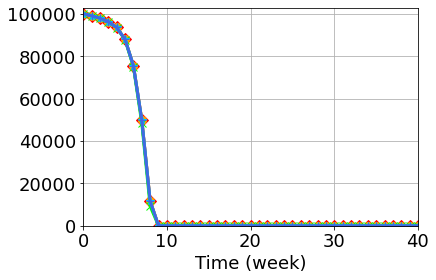

In [42]:
plot_to_compare_popluation_ovetime(I_population_none = simulation_test_population_none[0],
                                     I_population_c_and_s = simulation_test_population_c_and_s[0],
                                     I_population_c_only = simulation_test_population_c_only[0],
                                     I_population_random = simulation_test_population_random[0],
                                     I_population_s1c2 = simulation_test_population_s1c2[0],
                                     I_population_c1s2 = simulation_test_population_c1s2[0],
                                  exhibition_length = 40,
                                  size_font = 18)

# 7.2 Compare Exposed population overtime

7.2.1 Compare Exposed population overtime - no greedy

<Figure size 432x288 with 0 Axes>

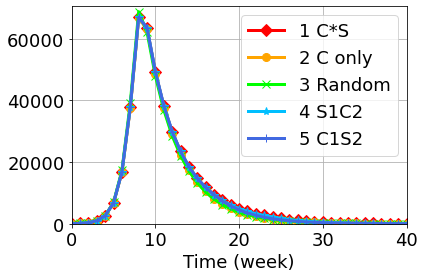

In [43]:
plot_to_compare_popluation_ovetime_legend(I_population_none = simulation_test_population_none[1],
                                     I_population_c_and_s = simulation_test_population_c_and_s[1],
                                     I_population_c_only = simulation_test_population_c_only[1],
                                     I_population_random = simulation_test_population_random[1],
                                     I_population_s1c2 = simulation_test_population_s1c2[1],
                                     I_population_c1s2 = simulation_test_population_c1s2[1],
                                  exhibition_length = 40,
                                  size_font = 18)

In [44]:
print("0 E = ", max(simulation_test_population_none[1]))
print("1 E = ", max(simulation_test_population_c_and_s[1]))
print("2 E = ", max(simulation_test_population_c_only[1]))
print("3 E = ", max(simulation_test_population_random[1]))
print("4 E = ", max(simulation_test_population_s1c2[1]))
print("5 E = ", max(simulation_test_population_c1s2[1]))

0 E =  81930.09787990883
1 E =  67026.91372011334
2 E =  66634.44507214782
3 E =  68818.00029233657
4 E =  67026.91372011334
5 E =  67026.91372011334


7.2.2 Compare Exposed population overtime - greedy

<Figure size 432x288 with 0 Axes>

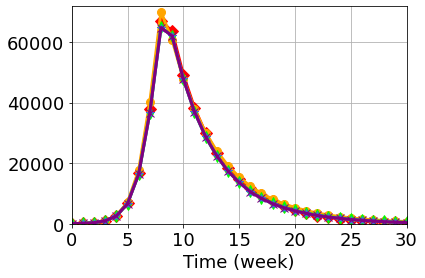

In [46]:
plot_to_compare_popluation_ovetime_greedy(I_population_none = simulation_test_population_none[1],
                                            I_population_strategy = simulation_test_population_c1s2[1],
                                        I_population_greedy_1 = simulation_test_population_greedy_2[1],
                                        I_population_greedy_2 = simulation_test_population_greedy_3[1],
                                        I_population_greedy_3 = simulation_test_population_greedy_4[1],
                                        I_population_greedy_4 = simulation_test_population_greedy_4[1],
                                         exhibition_length = 30,
                                  size_font = 18)

In [47]:
print("0 E = ", max(simulation_test_population_none[1]))
print("1 E = ", max(simulation_test_population_c1s2[1]))
print("2 E = ", max(simulation_test_population_greedy_2[1]))
print("3 E = ", max(simulation_test_population_greedy_3[1]))
print("4 E = ", max(simulation_test_population_greedy_4[1]))


0 E =  81930.09787990883
1 E =  67026.91372011334
2 E =  69999.94712348538
3 E =  64843.4376801793
4 E =  64765.76997396599


NameError: name 'simulation_test_population_greedy_5' is not defined

# 7.3 Compare Infected population overtime

7.3.1 Compare Infected population overtime - no greedy

<Figure size 432x288 with 0 Axes>

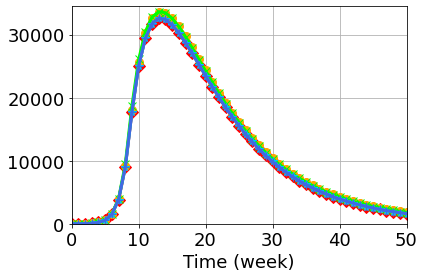

In [51]:
plot_to_compare_popluation_ovetime(I_population_none = simulation_test_population_none[3],
                                   I_population_c_and_s = simulation_test_population_c_and_s[3],
                                     I_population_c_only = simulation_test_population_c_only[3],
                                     I_population_random = simulation_test_population_random[3],
                                     I_population_s1c2 = simulation_test_population_s1c2[3],
                                     I_population_c1s2 = simulation_test_population_c1s2[3],
                                  exhibition_length = T,
                                  size_font = 18)

In [52]:
print("0 I = ", max(simulation_test_population_none[3]))
print("1 I = ", max(simulation_test_population_c_and_s[3]))
print("2 I = ", max(simulation_test_population_c_only[3]))
print("3 I = ", max(simulation_test_population_random[3]))
print("4 I = ", max(simulation_test_population_s1c2[3]))
print("5 I = ", max(simulation_test_population_c1s2[3]))

0 I =  37266.249303063116
1 I =  32596.55037771303
2 I =  33602.01027375327
3 I =  33646.98002819954
4 I =  32596.55037771303
5 I =  32596.55037771303


7.3.2 Compare Infected population overtime - greedy

<Figure size 432x288 with 0 Axes>

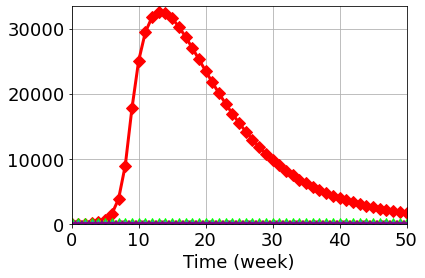

In [53]:
plot_to_compare_popluation_ovetime_greedy(I_population_none = simulation_test_population_none[3],
                                        I_population_strategy = simulation_test_population_c1s2[3],
                                        I_population_greedy_1 = simulation_test_population_greedy_2[3],
                                        I_population_greedy_2 = simulation_test_population_greedy_3[3],
                                        I_population_greedy_3 = simulation_test_population_greedy_4[3],
                                        I_population_greedy_4 = simulation_test_population_greedy_5[3],
                                         exhibition_length = T,
                                  size_font = 18)

In [150]:
print("0 I = ", max(simulation_test_population_none[3]))
print("1 I = ", max(simulation_test_population_c1s2[3]))
print("2 I = ", max(simulation_test_population_greedy_2[3]))
print("3 I = ", max(simulation_test_population_greedy_3[3]))
print("4 I = ", max(simulation_test_population_greedy_4[3]))
print("5 I = ", max(simulation_test_population_greedy_5[3]))

0 I =  37266.249303063116
1 I =  32596.55037771303
2 I =  32369.15290804382
3 I =  32560.49829527995
4 I =  32519.630879354605
5 I =  32743.61446639042


# 7.4 Compare Death population overtime

7.4.1 Compare Death population overtime - no greedy

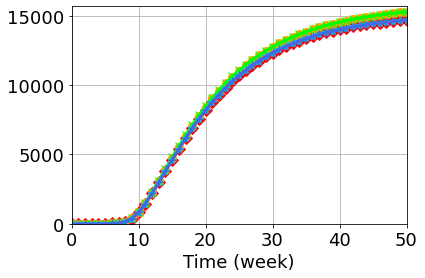

In [119]:
plot_to_compare_popluation_ovetime(I_population_none = simulation_test_population_none[5],
                                     I_population_c_and_s = simulation_test_population_c_and_s[5],
                                     I_population_c_only = simulation_test_population_c_only[5],
                                     I_population_random = simulation_test_population_random[5],
                                     I_population_s1c2 = simulation_test_population_s1c2[5],
                                     I_population_c1s2 = simulation_test_population_c1s2[5],
                                  exhibition_length = T,
                                  size_font = 18)

In [103]:
print("0 D = ", max(simulation_test_population_none[5]))
print("1 D = ", max(simulation_test_population_c_and_s[5]))
print("2 D = ", max(simulation_test_population_c_only[5]))
print("3 D = ", max(simulation_test_population_random[5]))
print("4 D = ", max(simulation_test_population_s1c2[5]))
print("5 D = ", max(simulation_test_population_c1s2[5]))

0 D =  17458.433791363146
1 D =  14710.884884979363
2 D =  15291.853271544502
3 D =  15281.76692529898
4 D =  14710.884884979363
5 D =  14685.715217246385


7.4.2 Compare Death population overtime - greedy

<Figure size 360x216 with 0 Axes>

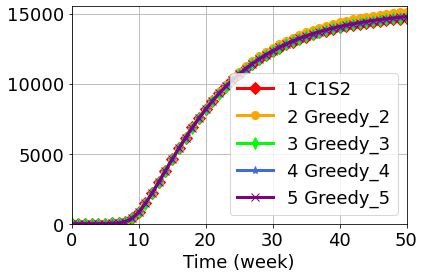

In [189]:
plot_to_compare_popluation_ovetime_greedy_legend(I_population_none = simulation_test_population_none[5],
                                        I_population_strategy = simulation_test_population_c1s2[5],
                                        I_population_greedy_1 = simulation_test_population_greedy_2[5],
                                        I_population_greedy_2 = simulation_test_population_greedy_3[5],
                                        I_population_greedy_3 = simulation_test_population_greedy_4[5],
                                        I_population_greedy_4 = simulation_test_population_greedy_5[5],
                                         exhibition_length = T,
                                  size_font = 18)

In [152]:
print("0 D = ", max(simulation_test_population_none[5]))
print("1 D = ", max(simulation_test_population_c1s2[5]))
print("2 D = ", max(simulation_test_population_greedy_2[5]))
print("3 D = ", max(simulation_test_population_greedy_3[5]))
print("4 D = ", max(simulation_test_population_greedy_4[5]))
print("5 D = ", max(simulation_test_population_greedy_5[5]))

0 D =  17458.433791363146
1 D =  14685.715217246385
2 D =  15134.622765993538
3 D =  14756.65957528255
4 D =  14775.311369884485
5 D =  14864.114069158999


# 7.5 Compare Vaccinated population overtime

7.5.1 Compare Vaccinated population overtime - no greedy

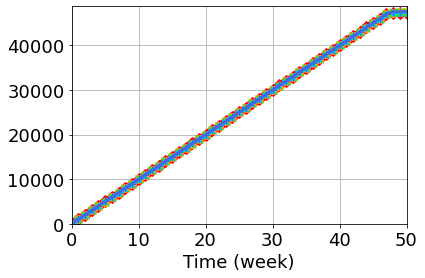

In [121]:
plot_to_compare_popluation_ovetime(I_population_none = simulation_test_population_none[6],
                                     I_population_c_and_s = simulation_test_population_c_and_s[6],
                                     I_population_c_only = simulation_test_population_c_only[6],
                                     I_population_random = simulation_test_population_random[6],
                                     I_population_s1c2 = simulation_test_population_s1c2[6],
                                     I_population_c1s2 = simulation_test_population_c1s2[6],
                                  exhibition_length = T,
                                  size_font = 18)

7.5.2 Compare Vaccinated population overtime - greedy

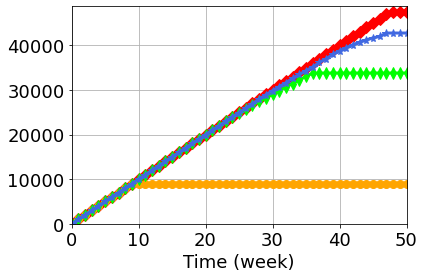

In [122]:
plot_to_compare_popluation_ovetime_greedy(I_population_none = simulation_test_population_none[6],
                                        I_population_strategy = simulation_test_population_c1s2[6],
                                        I_population_greedy_1 = simulation_test_population_greedy_1[6],
                                        I_population_greedy_2 = simulation_test_population_greedy_2[6],
                                        I_population_greedy_3 = simulation_test_population_greedy_3[6],
                                         exhibition_length = T,
                                  size_font = 18)

In [312]:
print("0 V = ", max(simulation_test_population_none[6]))
print("1 V = ", max(simulation_test_population_c1s2[6]))
print("2 V = ", max(simulation_test_population_greedy_1[6]))
print("3 V = ", max(simulation_test_population_greedy_2[6]))
print("4 V = ", max(simulation_test_population_greedy_3[6]))

0 V =  0.0
1 V =  47567.936140026206
2 V =  9004.500000000164
3 V =  33822.55383677183
4 V =  42777.87817647372


# VIII. Simulation of no vaccination

8.0 Input parameters

In [23]:
# Infection rate 0.02 ~ 0.6
Lambda_set = [0.05, 0.05]

# Exposed to infected rate 1/14 ~ 1/5
Gamma_set = [[1/5, 1/5], [1/5, 1/7], [1/5, 1/10], [1/5, 1/14],
             [1/7, 1/7], [1/7, 1/10], [1/7, 1/14],
             [1/10, 1/10], [1/10, 1/14],
             [1/14, 1/14]]

# Recovery rate for exposed 1/14
Sigma_E_set = [1/14, 1/14]    
# Cured rate for infected 1/20 ~ 1/10
Sigma_I_set = [1/20, 1/10]    
# Death rate (case fatality rate) 2.3% ~ 2.6%
Delta_set = [0.026, 0.023] 

# proportion corresponding to sensitivity clan
p_i_set = [[0.1, 0.9],[0.2, 0.8],[0.3, 0.7],[0.4, 0.6],[0.5, 0.5],[0.6, 0.4],[0.7, 0.3],[0.8, 0.2],[0.9, 0.1]]

# contact rates for different social activity level group
c_j_set = [[25, 15], [25, 10], [25, 5],
           [20, 15], [20, 10], [20, 5], 
           [15, 15], [15, 10], [15, 5],
           [10, 10], [10,  5], [5,  5]]
           
# proportion corresponding to contact rates
p_j_set = [[0.1, 0.9],[0.2, 0.8],[0.3, 0.7],[0.4, 0.6],[0.5, 0.5],[0.6, 0.4],[0.7, 0.3],[0.8, 0.2],[0.9, 0.1]]

# Population
T = 100        # Terminal time in week
T_greedy = 1  # number of periods used for greedy


S_0 = 100000    # Initial number of susceptible
R_0 = 0         # Initial number of recovered from E
I_0 = 0         # Initial number of infected 
C_0 = 0         # Initial number of recovered from R
D_0 = 0         # Initial number of Death
# No N_0, it will be calculated in the simulation function

coverage_time = 100
v_epsilon = 1
E_proportion_set = [0.0005, 0.001, 0.002, 0.005, 0.01]

E_index = 0
E_0 = E_proportion_set[E_index]*S_0

In [24]:
E_0

50.0

Define the heat function (for ease)

In [25]:
def heatmap_no_colorbar(x, font_size, color):
    fig, ax = plt.subplots(figsize=(5,4))
    res = sns.heatmap(x, 
                      annot=False, 
                      xticklabels=False, 
                      cbar=False,
                      cmap=color)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = font_size)
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = font_size)
    
def heatmap_with_colorbar(x, font_size, color):
    fig, ax = plt.subplots(figsize=(6,4))
    res = sns.heatmap(x,
                      annot=False, 
                      xticklabels=False, 
                      cbar=True,
                      cmap=color)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = font_size)
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = font_size)
    
    c_bar = res.collections[0].colorbar
    c_bar.ax.tick_params(labelsize = font_size)

Single simulation - Same sensitivity, different contact

In [26]:
simulation_no_v_0 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = 100,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [25, 15],
            contact_rate_proportion     = [0.9, 0.1],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/5, 1/5],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/20, 1/20],
            death_rate                  = [0.026, 0.026],
            sensitivity_proportion      = [0.9, 0.1],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

In [27]:
simulation_no_v_1 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [20, 15],
            contact_rate_proportion     = [0.7, 0.3],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/5, 1/5],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/20, 1/20],
            death_rate                  = [0.026, 0.026],
            sensitivity_proportion      = [0.9, 0.1],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

In [28]:
simulation_no_v_2 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [20, 10],
            contact_rate_proportion     = [0.5, 0.5],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/5, 1/5],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/20, 1/20],
            death_rate                  = [0.026, 0.026],
            sensitivity_proportion      = [0.9, 0.1],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

In [29]:
simulation_no_v_25 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [15, 10],
            contact_rate_proportion     = [0.6, 0.4],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/5, 1/5],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/20, 1/10],
            death_rate                  = [0.026, 0.026],
            sensitivity_proportion      = [0.9, 0.1],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

In [30]:
simulation_no_v_3 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [15, 10],
            contact_rate_proportion     = [0.3, 0.7],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/5, 1/5],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/20, 1/10],
            death_rate                  = [0.026, 0.026],
            sensitivity_proportion      = [0.9, 0.1],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

Single simulation - Same contact, different sensitivity

In [31]:
simulation_no_v_4 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [15, 15],
            contact_rate_proportion     = [0.5, 0.5],   
        
            infection_rate              = [0.04, 0.04],
            exposed_to_infected_rate    = [1/7, 1/14],
            recovery_rate_for_exposed   = [1/14, 1/10],
            cured_rate_for_infected     = [1/20, 1/7],
            death_rate                  = [0.026, 0.023],
            sensitivity_proportion      = [0.75, 0.25],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

In [32]:
simulation_no_v_5 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [15, 15],
            contact_rate_proportion     = [0.5, 0.5],
        
            infection_rate              = [0.03, 0.03],
            exposed_to_infected_rate    = [1/7, 1/14],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/14, 1/10],
            death_rate                  = [0.026, 0.023],
            sensitivity_proportion      = [0.8, 0.2],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

In [33]:
simulation_no_v_6 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [15, 15],
            contact_rate_proportion     = [0.5, 0.5],  
        
            infection_rate              = [0.025, 0.025],
            exposed_to_infected_rate    = [1/10, 1/14],
            recovery_rate_for_exposed   = [1/14, 1/10],
            cured_rate_for_infected     = [1/20, 1/10],
            death_rate                  = [0.026, 0.023],
            sensitivity_proportion      = [0.5, 0.5],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

In [34]:
simulation_no_v_100 = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [15, 15],
            contact_rate_proportion     = [0.5, 0.5],   
        
            infection_rate              = [0.02, 0.02],
            exposed_to_infected_rate    = [1/10, 1/14],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/14, 1/10],
            death_rate                  = [0.023, 0.02],
            sensitivity_proportion      = [0.3, 0.7],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_population_table
            )

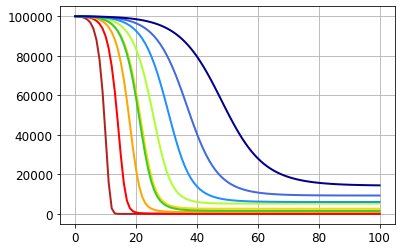

In [35]:
# S 0

plt.rcParams["figure.figsize"] = (6,4)

plt.plot(simulation_no_v_0[0], label = "severe", color="firebrick",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_1[0], label = "severe", color="red",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_2[0], label = "medium", color="orange",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_25[0], label = "medium", color="gold",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_3[0], label = "mild 1", color="greenyellow",     linewidth=2, markersize = 5)

plt.plot(simulation_no_v_4[0], label = "mild 2", color="limegreen",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_5[0], label = "mild 3", color="dodgerblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_6[0], label = "semi-mild", color="royalblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_100[0].T, label = "safe", color="darkblue",     linewidth=2, markersize = 5)

plt.grid()
plt.tick_params(labelsize = 12)

# plt.legend(title = "situation", loc = 'upper right', fontsize = 12)

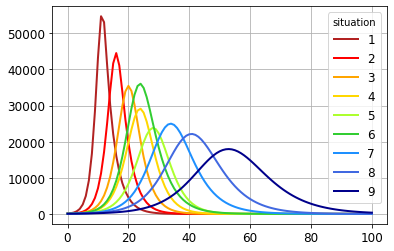

In [36]:
# E 1

plt.rcParams["figure.figsize"] = (6,4)

plt.plot(simulation_no_v_0[1], label = "1", color="firebrick",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_1[1], label = "2", color="red",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_2[1], label = "3", color="orange",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_25[1], label = "4", color="gold",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_3[1], label = "5", color="greenyellow",     linewidth=2, markersize = 5)

plt.plot(simulation_no_v_4[1], label = "6", color="limegreen",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_5[1], label = "7", color="dodgerblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_6[1], label = "8", color="royalblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_100[1].T, label = "9", color="darkblue",     linewidth=2, markersize = 5)

plt.grid()
plt.tick_params(labelsize = 12)

plt.legend(title = "situation", loc = 'upper right', fontsize = 12)

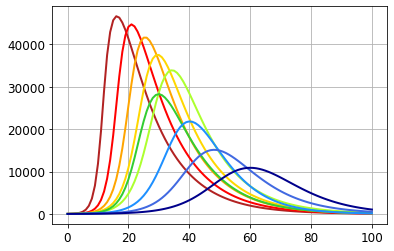

In [37]:
# I 3

plt.rcParams["figure.figsize"] = (6,4)

plt.plot(simulation_no_v_0[3], label = "severe", color="firebrick",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_1[3], label = "severe", color="red",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_2[3], label = "medium", color="orange",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_25[3], label = "medium", color="gold",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_3[3], label = "mild 1", color="greenyellow",     linewidth=2, markersize = 5)

plt.plot(simulation_no_v_4[3], label = "mild 2", color="limegreen",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_5[3], label = "mild 3", color="dodgerblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_6[3], label = "semi-mild", color="royalblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_100[3].T, label = "safe", color="darkblue",     linewidth=2, markersize = 5)

plt.grid()
plt.tick_params(labelsize = 12)

# plt.legend(title = "situation", loc = 'upper right', fontsize = 12)

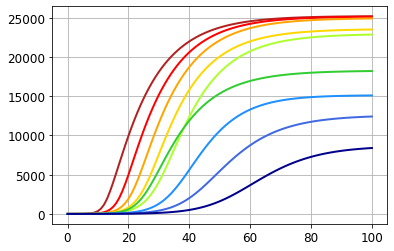

In [38]:
# D 5

plt.rcParams["figure.figsize"] = (6,4)

plt.plot(simulation_no_v_0[5], label = "severe", color="firebrick",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_1[5], label = "severe", color="red",      linewidth=2, markersize = 5)
plt.plot(simulation_no_v_2[5], label = "semi-severe", color="orange",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_25[5], label = "medium", color="gold",   linewidth=2, markersize = 5)
plt.plot(simulation_no_v_3[5], label = "medium 1", color="greenyellow",     linewidth=2, markersize = 5)

plt.plot(simulation_no_v_4[5], label = "medium 2", color="limegreen",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_5[5], label = "medium 3", color="dodgerblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_6[5], label = "semi-mild", color="royalblue",     linewidth=2, markersize = 5)
plt.plot(simulation_no_v_100[5].T, label = "safe", color="darkblue",     linewidth=2, markersize = 5)

plt.grid()
plt.tick_params(labelsize = 12)

# plt.legend(title = "situation", loc = 'upper left', fontsize = 12)

8.1 Given sensitivity, change contact

In [39]:
T = 50
sen_i = 6
sen_prop_i = 4

I_no_v_change_c = np.zeros((len(c_j_set),len(p_j_set)))
D_no_v_change_c = np.zeros((len(c_j_set),len(p_j_set)))

In [40]:
start_time = time.time()

for con_i in range(0, len(c_j_set)):
    for con_prop_i in range(0, len(p_j_set)):
        simulation_population_none = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = c_j_set[con_i],
            contact_rate_proportion     = p_j_set[con_prop_i],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/10, 1/10],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/14, 1/14],
            death_rate                  = [0.025, 0.025],
            sensitivity_proportion      = p_i_set[sen_prop_i],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        I_no_v_change_c[con_i,con_prop_i] = simulation_population_none[2]
        D_no_v_change_c[con_i,con_prop_i] = simulation_population_none[5]
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5386857986450195 seconds ---


In [41]:
I_no_v_change_c_table = pd.DataFrame(I_no_v_change_c, 
                                     columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['(25, 15)', '(25, 10)', '(25, 5)',
                                              '(20, 15)', '(20, 10)', '(20, 5)', 
                                              '(15, 15)', '(15, 10)', '(15, 5)',
                                              '(10, 10)', '(10, 5)' , '(5, 5)'])
# I_no_v_change_c_table

In [42]:
D_no_v_change_c_table = pd.DataFrame(D_no_v_change_c, 
                                     columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['(25, 15)', '(25, 10)', '(25, 5)',
                                              '(20, 15)', '(20, 10)', '(20, 5)', 
                                              '(15, 15)', '(15, 10)', '(15, 5)',
                                              '(10, 10)', '(10, 5)' , '(5, 5)'])
# D_no_v_change_c_table

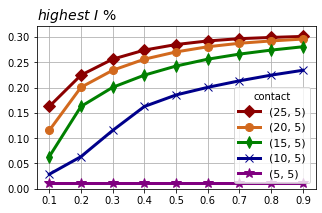

In [45]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_c_table.iloc[[2]].T, label = "(25, 5)", marker = 'D', color="darkred",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[5]].T, label = "(20, 5)", marker = 'o', color="chocolate",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[8]].T, label = "(15, 5)",  marker = 'd', color="green",     linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[10]].T, label = "(10, 5)",  marker = 'x', color="darkblue",     linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[11]].T, label = "(5, 5)",  marker = '*', color="purple",     linewidth=3, markersize = 10)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 14, loc='left')
plt.ylim(0, I_no_v_change_c[0,-1]+0.02)
plt.legend(title = "contact", loc = 'lower right', fontsize = 11)

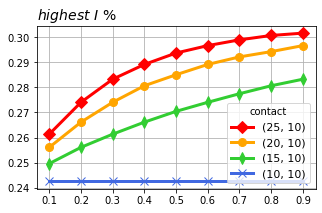

In [46]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_c_table.iloc[[1]].T, label = "(25, 10)", marker = 'D', color="red",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[4]].T, label = "(20, 10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[7]].T, label = "(15, 10)",  marker = 'd', color="limegreen",     linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[9]].T, label = "(10, 10)",  marker = 'x', color="royalblue",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 14, loc='left')
# plt.ylim(0, I_no_v_change_c[0,-1]+0.02)
plt.legend(title = "contact", loc = 'lower right', fontsize = 11)

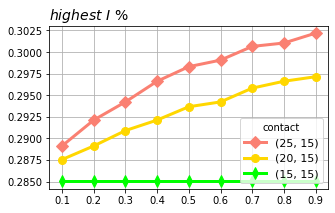

In [37]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_c_table.iloc[[0]].T, label = "(25, 15)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[3]].T, label = "(20, 15)", marker = 'o', color="gold",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[6]].T, label = "(15, 15)",  marker = 'd', color="lime",     linewidth=3, markersize = 8)



plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 14, loc='left')
# plt.ylim(0, I_no_v_change_c[0,-1]+0.02)
plt.legend(title = "contact", loc = 'lower right', fontsize = 11)

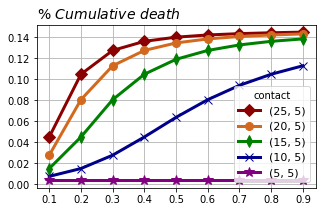

In [47]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_c_table.iloc[[2]].T, label = "(25, 5)", marker = 'D', color="darkred",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[5]].T, label = "(20, 5)", marker = 'o', color="chocolate",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[8]].T, label = "(15, 5)",  marker = 'd', color="green",     linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[10]].T, label = "(10, 5)",  marker = 'x', color="darkblue",     linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[11]].T, label = "(5, 5)",  marker = '*', color="purple",     linewidth=3, markersize = 10)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 14, loc='left')
# plt.ylim(0, D_no_v_change_c_table[0,-1]+0.02)
plt.legend(title = "contact", loc = 'lower right', fontsize = 11)

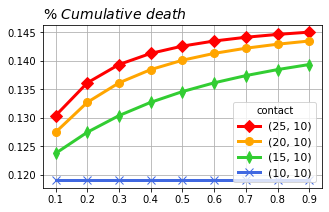

In [49]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_c_table.iloc[[1]].T, label = "(25, 10)", marker = 'D', color="red",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[4]].T, label = "(20, 10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[7]].T, label = "(15, 10)",  marker = 'd', color="limegreen",     linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[9]].T, label = "(10, 10)",  marker = 'x', color="royalblue",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 14, loc='left')
# plt.ylim(0, D_no_v_change_c_table[0,-1]+0.02)
plt.legend(title = "contact", loc = 'lower right', fontsize = 11)

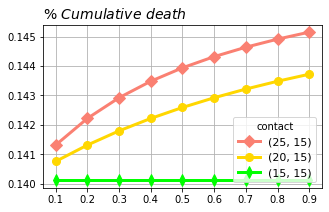

In [40]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_c_table.iloc[[0]].T, label = "(25, 15)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[3]].T, label = "(20, 15)", marker = 'o', color="gold",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[6]].T, label = "(15, 15)",  marker = 'd', color="lime",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 14, loc='left')
# plt.ylim(0, D_no_v_change_c_table[0,-1]+0.02)
plt.legend(title = "contact", loc = 'lower right', fontsize = 11)

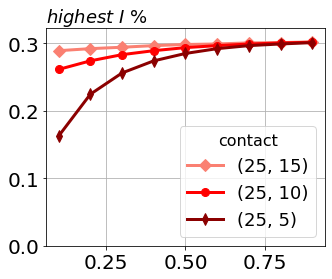

In [41]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(I_no_v_change_c_table.iloc[[0]].T, label = "(25, 15)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[1]].T, label = "(25, 10)", marker = 'o', color="red",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[2]].T, label = "(25, 5)",  marker = 'd', color="darkred",     linewidth=3, markersize = 8)

plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 18, loc='left')
plt.ylim(0, I_no_v_change_c[0,-1]+0.02)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)

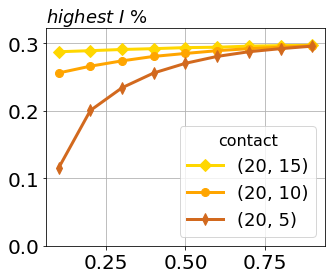

In [42]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(I_no_v_change_c_table.iloc[[3]].T, label = "(20, 15)", marker = 'D', color="gold",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[4]].T, label = "(20, 10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[5]].T, label = "(20, 5)",  marker = 'd', color="chocolate",     linewidth=3, markersize = 8)

plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 18, loc='left')
plt.ylim(0, I_no_v_change_c[0,-1]+0.02)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)

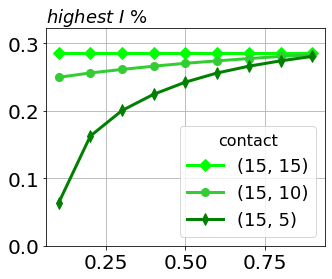

In [43]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(I_no_v_change_c_table.iloc[[6]].T, label = "(15, 15)", marker = 'D', color="lime",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[7]].T, label = "(15, 10)", marker = 'o', color="limegreen",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[8]].T, label = "(15, 5)",  marker = 'd', color="green",     linewidth=3, markersize = 8)

plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 18, loc='left')
plt.ylim(0, I_no_v_change_c[0,-1]+0.02)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)

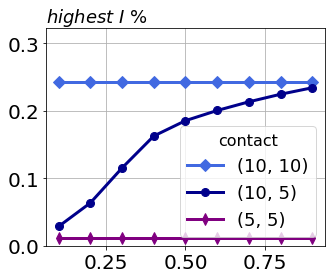

In [44]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(I_no_v_change_c_table.iloc[[9]].T,  label = "(10, 10)", marker = 'D', color="royalblue",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[10]].T, label = "(10, 5)", marker = 'o', color="darkblue",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_c_table.iloc[[11]].T, label = "(5, 5)",  marker = 'd', color="purple",     linewidth=3, markersize = 8)

plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 18, loc='left')
plt.ylim(0, I_no_v_change_c[0,-1]+0.02)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)

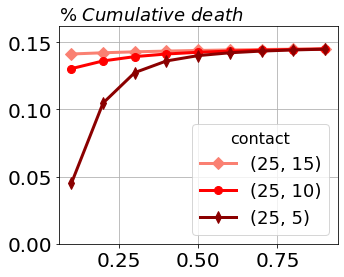

In [45]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(D_no_v_change_c_table.iloc[[0]].T, label = "(25, 15)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[1]].T, label = "(25, 10)", marker = 'o', color="red",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[2]].T, label = "(25, 5)",  marker = 'd', color="darkred",     linewidth=3, markersize = 8)
    
plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 18, loc='left')
plt.ylim(0, 0.151885+0.01)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)

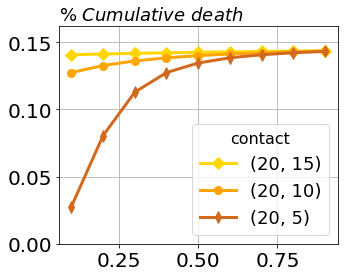

In [46]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(D_no_v_change_c_table.iloc[[3]].T, label = "(20, 15)", marker = 'D', color="gold",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[4]].T, label = "(20, 10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[5]].T, label = "(20, 5)",  marker = 'd', color="chocolate",     linewidth=3, markersize = 8)
    
plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 18, loc='left')
plt.ylim(0, 0.151885+0.01)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)

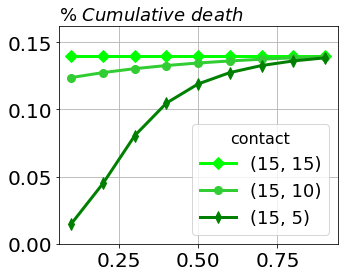

In [47]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(D_no_v_change_c_table.iloc[[6]].T, label = "(15, 15)", marker = 'D', color="lime",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[7]].T, label = "(15, 10)", marker = 'o', color="limegreen",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[8]].T, label = "(15, 5)",  marker = 'd', color="green",     linewidth=3, markersize = 8)
    
plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 18, loc='left')
plt.ylim(0, 0.151885+0.01)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)


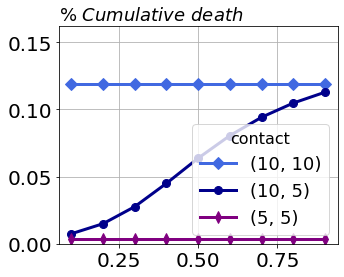

In [48]:
plt.rcParams["figure.figsize"] = (5,4)

plt.plot(D_no_v_change_c_table.iloc[[9]].T, label = "(10, 10)", marker = 'D', color="royalblue",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[10]].T, label = "(10, 5)", marker = 'o', color="darkblue",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_c_table.iloc[[11]].T, label = "(5, 5)",  marker = 'd', color="purple",     linewidth=3, markersize = 8)
    
plt.grid()
plt.tick_params(labelsize = 20)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 18, loc='left')
plt.ylim(0, 0.151885+0.01)
lg = plt.legend(title = "contact", loc = 'lower right', fontsize = 18)
lg.get_title().set_fontsize(16)

8.1.1 extension, change contact by 1 each time, given sensitivity

In [93]:
T = 50

constant_c = 25
# constant_c_set = [[25, 25], [20, 20], [15, 15], [10, 10], [5, 5]]

p_c_h = 0.05
p_c_l = 1-p_c_h
p_c_change = 0.05
p_c_len = 19 # = 1 + (p_s_l - p_s_h)/p_s_change

I_no_v_change_c = np.zeros((constant_c,p_c_len))
D_no_v_change_c = np.zeros((constant_c,p_c_len))

In [94]:
start_time = time.time()

for con_i in range(0, constant_c):
    for con_prop_i in range(0, p_c_len):
        simulation_population_none = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [constant_c, constant_c - con_i],
            contact_rate_proportion     = [p_c_h + con_prop_i * p_c_change , 1 - (p_c_h + con_prop_i * p_c_change)],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/10, 1/10],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/14, 1/14],
            death_rate                  = [0.025, 0.025],
            sensitivity_proportion      = p_i_set[0],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        I_no_v_change_c[con_i,con_prop_i] = simulation_population_none[2]
        D_no_v_change_c[con_i,con_prop_i] = simulation_population_none[5]
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.3650689125061035 seconds ---


In [95]:
I_no_v_change_c_table = pd.DataFrame(I_no_v_change_c,
#                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['25', ' ', ' ', ' ', '21',
                                              '', '', ' ', '17 ', ' ',
                                              '', ' ', '13 ', ' ', ' ',
                                              ' ', '9 ', ' ', ' ', ' ',
                                              '5', ' ', ' ', ' ', '1',])
# I_no_v_change_c_table = pd.DataFrame(I_no_v_change_c)
# I_no_v_change_c_table

In [96]:
D_no_v_change_c_table = pd.DataFrame(D_no_v_change_c,
#                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['25', ' ', ' ', ' ', '21',
                                              '', '', ' ', '17 ', ' ',
                                              '', ' ', '13 ', ' ', ' ',
                                              ' ', '9 ', ' ', ' ', ' ',
                                              '5', ' ', ' ', ' ', '1',])
# D_no_v_change_c_table = pd.DataFrame(D_no_v_change_c)
# D_no_v_change_c_table

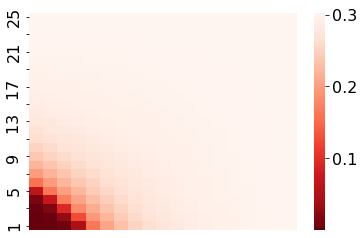

In [97]:
# heatmap_no_colorbar(I_no_v_change_c_table, 16, "Reds_r")
heatmap_with_colorbar(I_no_v_change_c_table, 16, "Reds_r")

Proportion of infected population (highest value over time)

X: proportion of high-contact group, from 0 to 1 with increment of 0.05

Y: high contact rate = 25, low contact rate changing from 25 to 1

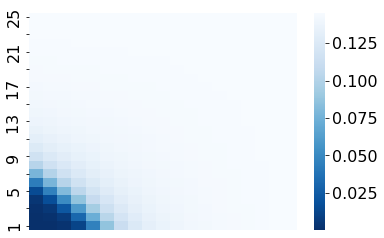

In [98]:
# heatmap_no_colorbar(D_no_v_change_c_table, 16, "Blues_r")
heatmap_with_colorbar(D_no_v_change_c_table, 16, "Blues_r")

8.1.2 - Extension, more change to high contact rate

In [153]:
T = 50

max_constant_c = 25
min_constant_c = 5
c_change = 1 + (max_constant_c - min_constant_c)

p_c_h = 0.05
p_c_l = 1-p_c_h
p_c_change = 0.05
p_c_len = 19 # = 1 + (p_s_l - p_s_h)/p_s_change

I_no_v_change_c = np.zeros((c_change,p_c_len))
D_no_v_change_c = np.zeros((c_change,p_c_len))

In [154]:
start_time = time.time()

for con_i in range(0, c_change):
    for con_prop_i in range(0, p_c_len):
        simulation_population_none = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [max_constant_c - con_i, min_constant_c],
            contact_rate_proportion     = [p_c_h + con_prop_i * p_c_change , 1 - (p_c_h + con_prop_i * p_c_change)],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/10, 1/10],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/14, 1/14],
            death_rate                  = [0.025, 0.025],
            sensitivity_proportion      = p_i_set[0],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        I_no_v_change_c[con_i,con_prop_i] = simulation_population_none[2]
        D_no_v_change_c[con_i,con_prop_i] = simulation_population_none[5]
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.015113115310669 seconds ---


In [160]:
I_no_v_change_c_table = pd.DataFrame(I_no_v_change_c,
#                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['25', ' ', ' ', ' 22', '',
                                              '20', '', ' ', '17 ', ' ',
                                              '', ' 14', ' ', ' ', '11 ',
                                              ' ', ' ', '8 ', ' ', ' ',
                                              '5'])
# I_no_v_change_c_table = pd.DataFrame(I_no_v_change_c)
# I_no_v_change_c_table

In [156]:
# D_no_v_change_c_table = pd.DataFrame(D_no_v_change_c,
# #                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#                                      index = ['25', ' ', ' ', ' ', '21',
#                                               '', '', ' ', '17 ', ' ',
#                                               '', ' ', '13 ', ' ', ' ',
#                                               ' ', '9 ', ' ', ' ', ' ',
#                                               '5', ' ', ' ', ' ', '1',])
D_no_v_change_c_table = pd.DataFrame(D_no_v_change_c)
# D_no_v_change_c_table

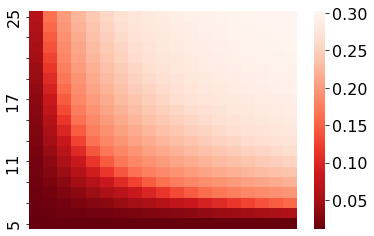

In [161]:
# heatmap_no_colorbar(I_no_v_change_c_table, 16, "Reds_r")
heatmap_with_colorbar(I_no_v_change_c_table, 16, "Reds_r")

Proportion of infected population (highest value over time)

X: proportion of high-contact group, from 0 to 1 with increment of 0.05

Y: low contact rate = 15, low contact rate changing from 25 to 15

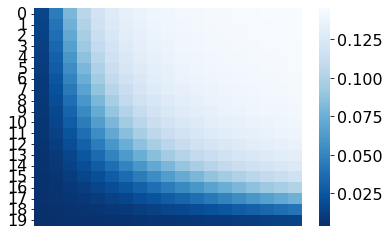

In [149]:
# heatmap_no_colorbar(D_no_v_change_c_table, 16, "Blues_r")
heatmap_with_colorbar(D_no_v_change_c_table, 16, "Blues_r")

8.2 Given contact, change sensitivity

In [50]:
con_i = 4
con_prop_i = 4
T = 50

I_no_v_change_s = np.zeros((len(Gamma_set),len(p_i_set)))
D_no_v_change_s = np.zeros((len(Gamma_set),len(p_i_set)))

In [51]:
for sen_i in range(0, len(Gamma_set)):
    for sen_prop_i in range(0, len(p_i_set)):
        simulation_population_none = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [15, 15],
            contact_rate_proportion     = p_j_set[con_prop_i],   
        
            infection_rate              = Lambda_set,
            exposed_to_infected_rate    = Gamma_set[sen_i],
            recovery_rate_for_exposed   = Sigma_E_set,
            cured_rate_for_infected     = Sigma_I_set,
            death_rate                  = Delta_set,
            sensitivity_proportion      = p_i_set[sen_prop_i],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        I_no_v_change_s[sen_i,sen_prop_i] = simulation_population_none[2]
        D_no_v_change_s[sen_i,sen_prop_i] = simulation_population_none[5]

In [52]:
I_no_v_change_s_table = pd.DataFrame(I_no_v_change_s, 
                                     columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['(1/5, 1/5)', '(1/5, 1/7)', '(1/5, 1/10)', '(1/5, 1/14)', 
                                              '(1/7, 1/7)', '(1/7, 1/10)', '(1/7, 1/14)', 
                                              '(1/10, 1/10)', '(1/10, 1/14)',
                                              '(1/14, 1/14)'])
# I_no_v_change_s_table

In [53]:
D_no_v_change_s_table = pd.DataFrame(D_no_v_change_s, 
                                     columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['(1/5, 1/5)', '(1/5, 1/7)', '(1/5, 1/10)', '(1/5, 1/14)', 
                                              '(1/7, 1/7)', '(1/7, 1/10)', '(1/7, 1/14)', 
                                              '(1/10, 1/10)', '(1/10, 1/14)',
                                              '(1/14, 1/14)'])
# D_no_v_change_s_table

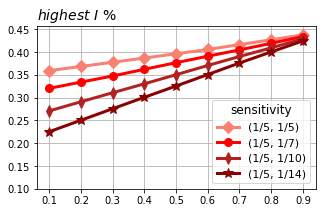

In [54]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_s_table.iloc[[0]].T, label = "(1/5, 1/5)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[1]].T, label = "(1/5, 1/7)", marker = 'o', color="red",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[2]].T, label = "(1/5, 1/10)",  marker = 'd', color="firebrick",     linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[3]].T, label = "(1/5, 1/14)",  marker = '*', color="darkred",     linewidth=3, markersize = 11)

plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 14, loc='left')
plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'lower right', fontsize = 11)
lg.get_title().set_fontsize(12)

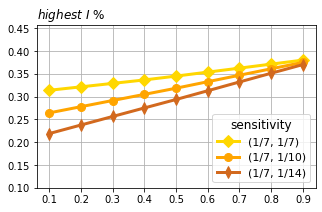

In [55]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_s_table.iloc[[4]].T, label = "(1/7, 1/7)", marker = 'D', color="gold",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[5]].T, label = "(1/7, 1/10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[6]].T, label = "(1/7, 1/14)",  marker = 'd', color="chocolate",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 12, loc='left')
plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'lower right', fontsize = 11)
lg.get_title().set_fontsize(12)

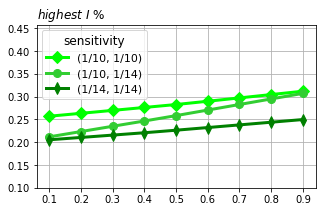

In [56]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_s_table.iloc[[7]].T, label = "(1/10, 1/10)", marker = 'D', color="lime",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[8]].T, label = "(1/10, 1/14)", marker = 'o', color="limegreen",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[9]].T, label = "(1/14, 1/14)",  marker = 'd', color="green",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 12, loc='left')
plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

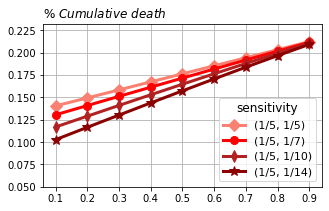

In [57]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_s_table.iloc[[0]].T, label = "(1/5, 1/5)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[1]].T, label = "(1/5, 1/7)", marker = 'o', color="red",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[2]].T, label = "(1/5, 1/10)",  marker = 'd', color="firebrick",     linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[3]].T, label = "(1/5, 1/14)",  marker = '*', color="darkred",     linewidth=3, markersize = 11)

plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 12, loc='left')
plt.ylim(0.05, D_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'lower right', fontsize = 11)
lg.get_title().set_fontsize(12)

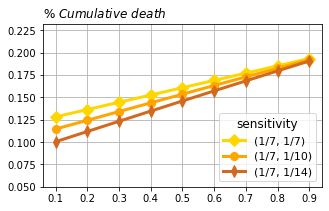

In [58]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_s_table.iloc[[4]].T, label = "(1/7, 1/7)", marker = 'D', color="gold",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[5]].T, label = "(1/7, 1/10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[6]].T, label = "(1/7, 1/14)",  marker = 'd', color="chocolate",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 12, loc='left')
plt.ylim(0.05, D_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'lower right', fontsize = 11)
lg.get_title().set_fontsize(12)

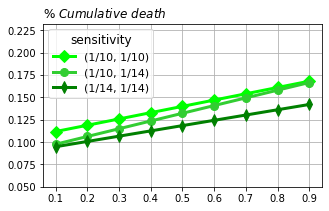

In [59]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_s_table.iloc[[7]].T, label = "(1/10, 1/10)", marker = 'D', color="lime",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[8]].T, label = "(1/10, 1/14)", marker = 'o', color="limegreen",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[9]].T, label = "(1/14, 1/14)",  marker = 'd', color="green",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 12, loc='left')
plt.ylim(0.05, D_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

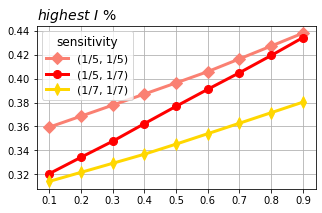

In [60]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_s_table.iloc[[0]].T, label = "(1/5, 1/5)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[1]].T, label = "(1/5, 1/7)", marker = 'o', color="red",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[4]].T, label = "(1/7, 1/7)", marker = 'd', color="gold",      linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 14, loc='left')
# plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

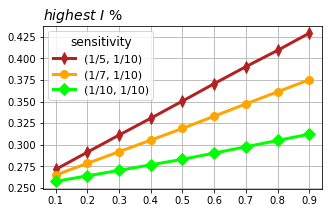

In [61]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_s_table.iloc[[2]].T, label = "(1/5, 1/10)",  marker = 'd', color="firebrick",     linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[5]].T, label = "(1/7, 1/10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[7]].T, label = "(1/10, 1/10)", marker = 'D', color="lime",      linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 14, loc='left')
# plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

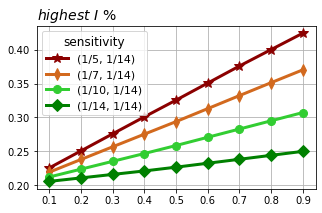

In [63]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(I_no_v_change_s_table.iloc[[3]].T, label = "(1/5, 1/14)",  marker = '*', color="darkred",     linewidth=3, markersize = 11)
plt.plot(I_no_v_change_s_table.iloc[[6]].T, label = "(1/7, 1/14)",  marker = 'd', color="chocolate",     linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[8]].T, label = "(1/10, 1/14)", marker = 'o', color="limegreen",   linewidth=3, markersize = 8)
plt.plot(I_no_v_change_s_table.iloc[[9]].T, label = "(1/14, 1/14)",  marker = 'D', color="green",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$highest \ I \ \%$', fontsize = 14, loc='left')
# plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

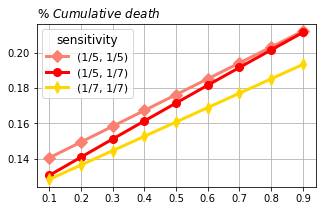

In [64]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_s_table.iloc[[0]].T, label = "(1/5, 1/5)", marker = 'D', color="salmon",      linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[1]].T, label = "(1/5, 1/7)", marker = 'o', color="red",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[4]].T, label = "(1/7, 1/7)", marker = 'd', color="gold",      linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 12, loc='left')
# plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

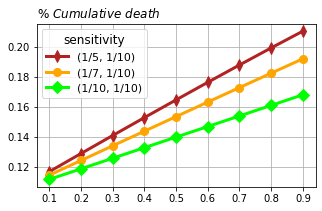

In [129]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_s_table.iloc[[2]].T, label = "(1/5, 1/10)",  marker = 'd', color="firebrick",     linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[5]].T, label = "(1/7, 1/10)", marker = 'o', color="orange",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[7]].T, label = "(1/10, 1/10)", marker = 'D', color="lime",      linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 12, loc='left')
# plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

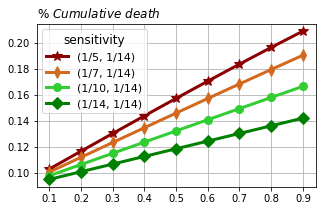

In [65]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(D_no_v_change_s_table.iloc[[3]].T, label = "(1/5, 1/14)",  marker = '*', color="darkred",     linewidth=3, markersize = 11)
plt.plot(D_no_v_change_s_table.iloc[[6]].T, label = "(1/7, 1/14)",  marker = 'd', color="chocolate",     linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[8]].T, label = "(1/10, 1/14)", marker = 'o', color="limegreen",   linewidth=3, markersize = 8)
plt.plot(D_no_v_change_s_table.iloc[[9]].T, label = "(1/14, 1/14)",  marker = 'D', color="green",     linewidth=3, markersize = 8)


plt.grid()
plt.tick_params(labelsize = 10)
# plt.xlabel(r'$p^h$', fontsize = 12, loc='right')
plt.title(r'$\% \ Cumulative \ death$', fontsize = 12, loc='left')
# plt.ylim(0.1, I_no_v_change_s[0,-1]+0.02)
lg = plt.legend(title = "sensitivity", loc = 'upper left', fontsize = 11)
lg.get_title().set_fontsize(12)

8.2.1 extension - change low sensitivity, given contact rate

In [172]:
T = 50

our_constant_c = 15

max_gamma_day = 5
min_gamma_day = 14
s_change = 1 + (min_gamma_day - max_gamma_day)

p_s_h = 0.05
p_s_l = 1-p_s_h
p_s_change = 0.05
p_s_len = 19 # = 1 + (p_s_l - p_s_h)/p_s_change

I_no_v_change_s = np.zeros((s_change,p_s_len))
D_no_v_change_s = np.zeros((s_change,p_s_len))

In [173]:
for sen_i in range(0, s_change):
    for sen_prop_i in range(0, p_s_len):
        simulation_population_none = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [our_constant_c, our_constant_c],
            contact_rate_proportion     = p_j_set[0],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/max_gamma_day, 1/(max_gamma_day + sen_i)],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/20, 1/10],
            death_rate                  = [0.026, 0.023],
            sensitivity_proportion      = [p_s_h + (sen_prop_i*p_s_change), 1 - (p_s_h + (sen_prop_i*p_s_change))],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        I_no_v_change_s[sen_i,sen_prop_i] = simulation_population_none[2]
        D_no_v_change_s[sen_i,sen_prop_i] = simulation_population_none[5]

In [182]:
I_no_v_change_s_table = pd.DataFrame(I_no_v_change_s)
# print(I_no_v_change_s_table)

In [175]:
D_no_v_change_s_table = pd.DataFrame(D_no_v_change_s)
# D_no_v_change_s_table

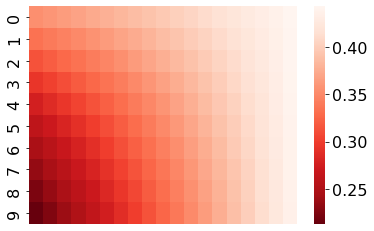

In [180]:
# heatmap_no_colorbar(I_no_v_change_s_table, 16, "Reds_r")
heatmap_with_colorbar(I_no_v_change_s_table, 16, "Reds_r")

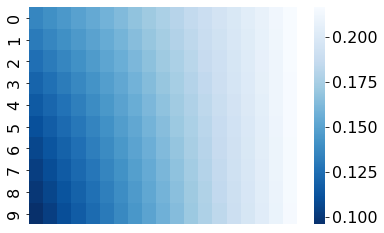

In [181]:
# heatmap_no_colorbar(D_no_v_change_s_table, 16, "Blues_r")
heatmap_with_colorbar(D_no_v_change_s_table, 16, "Blues_r")

8.2.2 extension - change high sensitivity, given contact rate

In [183]:
T = 50

our_constant_c = 15

max_gamma_day = 5
min_gamma_day = 14
s_change = 1 + (min_gamma_day - max_gamma_day)

p_s_h = 0.05
p_s_l = 1-p_s_h
p_s_change = 0.05
p_s_len = 19 # = 1 + (p_s_l - p_s_h)/p_s_change

I_no_v_change_s = np.zeros((s_change,p_s_len))
D_no_v_change_s = np.zeros((s_change,p_s_len))

In [184]:
for sen_i in range(0, s_change):
    for sen_prop_i in range(0, p_s_len):
        simulation_population_none = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [our_constant_c, our_constant_c],
            contact_rate_proportion     = p_j_set[0],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/(max_gamma_day+sen_i), 1/min_gamma_day],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/20, 1/10],
            death_rate                  = [0.026, 0.023],
            sensitivity_proportion      = [p_s_h + (sen_prop_i*p_s_change), 1 - (p_s_h + (sen_prop_i*p_s_change))],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        I_no_v_change_s[sen_i,sen_prop_i] = simulation_population_none[2]
        D_no_v_change_s[sen_i,sen_prop_i] = simulation_population_none[5]

In [185]:
I_no_v_change_s_table = pd.DataFrame(I_no_v_change_s)
# print(I_no_v_change_s_table)

In [186]:
D_no_v_change_s_table = pd.DataFrame(D_no_v_change_s)
# print(I_no_v_change_s_table)

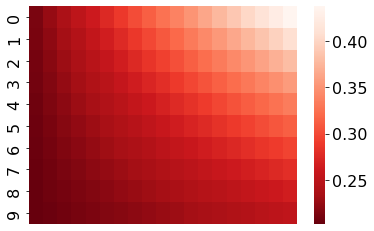

In [187]:
# heatmap_no_colorbar(I_no_v_change_s_table, 16, "Reds_r")
heatmap_with_colorbar(I_no_v_change_s_table, 16, "Reds_r")

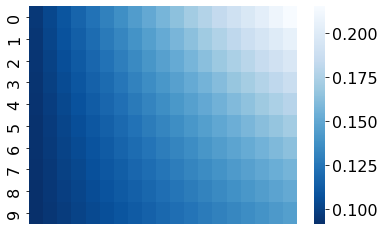

In [188]:
# heatmap_no_colorbar(D_no_v_change_s_table, 16, "Blues_r")
heatmap_with_colorbar(D_no_v_change_s_table, 16, "Blues_r")

8.3 Only change the contact rate for high sensitivity people

In [227]:
our_gamma = [1/7, 1/10]
our_contact_change_factor = 2

T = 50

constant_c = 25
# constant_c_set = [[25, 25], [20, 20], [15, 15], [10, 10], [5, 5]]

p_s_h = 0.05
p_s_l = 1-p_s_h
p_s_change = 0.025
p_s_len = 39 # = 1 + (p_s_l - p_s_h)/p_s_change

# record the percentage of change
I_no_v_partial_change_c = np.zeros((constant_c,p_s_len))
D_no_v_partial_change_c = np.zeros((constant_c,p_s_len))

I_no_v_partial_change_c_proportion_change = np.zeros((constant_c,p_s_len))
D_no_v_partial_change_c_proportion_change = np.zeros((constant_c,p_s_len))

In [228]:
for con_prop_i in range(0, constant_c):
    for sen_prop_i in range(0, p_s_len):
        nochange = SEIR_simulation_partial_change_c(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [constant_c-con_prop_i, constant_c-con_prop_i],
            contact_rate_proportion     = p_j_set[0],   # uniform c, proportion does not matter
            contact_change_factor       = 1,   # contact rate no change
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = our_gamma,
            recovery_rate_for_exposed   = [1/14, 1/7],
            cured_rate_for_infected     = [1/20, 1/10],
            death_rate                  = [0.026, 0.023],
            sensitivity_proportion      = [p_s_h + sen_prop_i* p_s_change, 1 - (p_s_h + sen_prop_i* p_s_change)],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        
        withchange = SEIR_simulation_partial_change_c(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = [constant_c-con_prop_i, constant_c-con_prop_i],
            contact_rate_proportion     = p_j_set[0],   # uniform c, proportion does not matter
            contact_change_factor       = our_contact_change_factor,
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = our_gamma,
            recovery_rate_for_exposed   = [1/14, 1/7],
            cured_rate_for_infected     = [1/20, 1/10],
            death_rate                  = [0.026, 0.023],
            sensitivity_proportion      = [p_s_h + sen_prop_i* p_s_change, 1 - (p_s_h + sen_prop_i* p_s_change)],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        
        I_no_v_partial_change_c[con_prop_i,sen_prop_i] = nochange[0] - withchange[0]
        D_no_v_partial_change_c[con_prop_i,sen_prop_i] = nochange[4] - withchange[4]
        
        I_no_v_partial_change_c_proportion_change[con_prop_i,sen_prop_i] = (nochange[0] - withchange[0])/nochange[0]
        D_no_v_partial_change_c_proportion_change[con_prop_i,sen_prop_i] = (nochange[4] - withchange[4])/nochange[4]

Define the heat function (for ease)

In [231]:
I_improve_no_v_partial_change_c_table = pd.DataFrame(I_no_v_partial_change_c,
#                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['25', ' ', ' ', ' ', '21',
                                              '', '', ' ', '17 ', ' ',
                                              '', ' ', '13 ', ' ', ' ',
                                              ' ', '9 ', ' ', ' ', ' ',
                                              '5', ' ', ' ', ' ', '1',])
# I_improve_no_v_partial_change_c_table

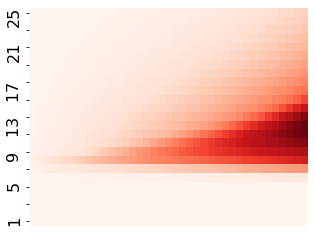

In [232]:
heatmap_no_colorbar(I_improve_no_v_partial_change_c_table, 16, "Reds")
# heatmap_with_colorbar(I_improve_no_v_partial_change_c_table, 16, "Reds")

In [233]:
I_no_v_partial_change_c_proportion_change_table = pd.DataFrame(I_no_v_partial_change_c_proportion_change,
#                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['25', ' ', ' ', ' ', '21',
                                              '', '', ' ', '17 ', ' ',
                                              '', ' ', '13 ', ' ', ' ',
                                              ' ', '9 ', ' ', ' ', ' ',
                                              '5', ' ', ' ', ' ', '1',])
# I_no_v_partial_change_c_proportion_change_table

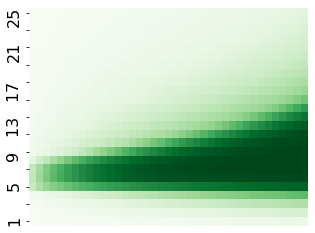

In [234]:
heatmap_no_colorbar(I_no_v_partial_change_c_proportion_change_table, 16, "Greens")
# heatmap_with_colorbar(I_no_v_partial_change_c_proportion_change_table, 16, "Greens")

In [235]:
D_improve_no_v_partial_change_c_table = pd.DataFrame(D_no_v_partial_change_c, 
#                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['25', ' ', ' ', ' ', '21',
                                              '', '', ' ', '17 ', ' ',
                                              '', ' ', '13 ', ' ', ' ',
                                              ' ', '9 ', ' ', ' ', ' ',
                                              '5', ' ', ' ', ' ', '1',])
# D_improve_no_v_partial_change_c_table

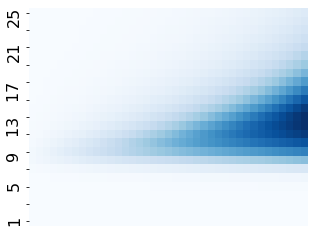

In [236]:
heatmap_no_colorbar(D_improve_no_v_partial_change_c_table, 16, "Blues")
# heatmap_with_colorbar(D_improve_no_v_partial_change_c_table, 16, "Blues")

In [237]:
D_no_v_partial_change_c_proportion_change_table = pd.DataFrame(D_no_v_partial_change_c_proportion_change, 
#                                      columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = ['25', ' ', ' ', ' ', '21',
                                              '', '', ' ', '17 ', ' ',
                                              '', ' ', '13 ', ' ', ' ',
                                              ' ', '9 ', ' ', ' ', ' ',
                                              '5', ' ', ' ', ' ', '1',])
# D_no_v_partial_change_c_proportion_change_table

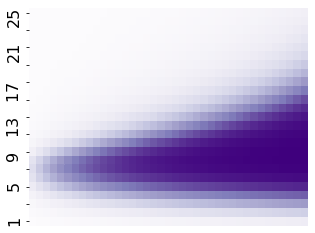

In [238]:
heatmap_no_colorbar(D_no_v_partial_change_c_proportion_change_table, 16, "Purples")
# heatmap_with_colorbar(D_no_v_partial_change_c_proportion_change_table, 16, "Purples")

8.4 Only change the sensitivity for high contact people - result hard to catch a pattern, will not present

In [42]:
sen_i = 2
con_i = 4

# record the percentage of change
I_no_v_partial_change_s = np.zeros((len(p_j_set),len(p_i_set)))
D_no_v_partial_change_s = np.zeros((len(p_j_set),len(p_i_set)))

In [46]:
for con_prop_i in range(0, len(p_j_set)):
    for sen_prop_i in range(0, len(p_i_set)):
        nochange = SEIR_simulation(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = c_j_set[con_i],
            contact_rate_proportion     = p_j_set[con_prop_i],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/10, 1/10],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/14, 1/14],
            death_rate                  = [0.025, 0.025],
            sensitivity_proportion      = p_i_set[sen_prop_i],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        
        withchange = SEIR_simulation_partial_change_s(
            terminal_time               = T,
            susceptible_population      = S_0, exposed_population          = E_0,
            recovered_population        = R_0, infected_population         = I_0,
            cured_population            = C_0, deaded_population           = D_0,
        
            contact_rate                = c_j_set[con_i],
            contact_rate_proportion     = p_j_set[con_prop_i],   
        
            infection_rate              = [0.05, 0.05],
            exposed_to_infected_rate    = [1/10, 1/10],
            recovery_rate_for_exposed   = [1/14, 1/14],
            cured_rate_for_infected     = [1/14, 1/14],
            death_rate                  = [0.025, 0.025],
            sensitivity_proportion      = p_i_set[sen_prop_i],
    
            vaccination_strategy        = no_vaccination,
            vaccine_efficacy            = v_epsilon,
            vaccine_coverage_time       = coverage_time,
            total_time_for_greedy       = T_greedy,

            output_presenting_function  = give_performance_table
            )
        I_no_v_partial_change_s[con_prop_i,sen_prop_i] = (nochange[2] - withchange[2])/nochange[2]
        D_no_v_partial_change_s[con_prop_i,sen_prop_i] = (nochange[5] - withchange[5])/nochange[5]

In [47]:
Gamma_set[sen_i], c_j_set[con_i]

([0.2, 0.1], [20, 10])

In [48]:
I_improve_no_v_partial_change_s_table = pd.DataFrame(I_no_v_partial_change_s, 
                                     columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
I_improve_no_v_partial_change_s_table

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.1,0.055784,0.055784,0.055784,0.055784,0.055784,0.055784,0.055784,0.055784,0.055784
0.2,0.095834,0.095834,0.095834,0.095834,0.095834,0.095834,0.095834,0.095834,0.095834
0.3,0.127730,0.127730,0.127730,0.127730,0.127730,0.127730,0.127730,0.127730,0.127730
0.4,0.151451,0.151451,0.151451,0.151451,0.151451,0.151451,0.151451,0.151451,0.151451
0.5,0.163080,0.163080,0.163080,0.163080,0.163080,0.163080,0.163080,0.163080,0.163080
0.6,0.167603,0.167603,0.167603,0.167603,0.167603,0.167603,0.167603,0.167603,0.167603
0.7,0.161203,0.161203,0.161203,0.161203,0.161203,0.161203,0.161203,0.161203,0.161203
0.8,0.146193,0.146193,0.146193,0.146193,0.146193,0.146193,0.146193,0.146193,0.146193
0.9,0.127809,0.127809,0.127809,0.127809,0.127809,0.127809,0.127809,0.127809,0.127809


<AxesSubplot:>

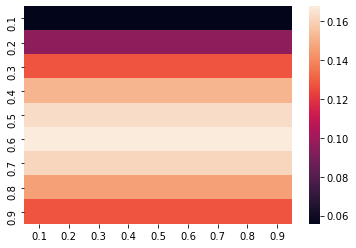

In [49]:
sns.heatmap(I_improve_no_v_partial_change_s_table, annot=False)

In [50]:
D_improve_no_v_partial_change_s_table = pd.DataFrame(D_no_v_partial_change_s, 
                                     columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                                     index = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
D_improve_no_v_partial_change_s_table

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.1,-0.045932,-0.045932,-0.045932,-0.045932,-0.045932,-0.045932,-0.045932,-0.045932,-0.045932
0.2,-0.097385,-0.097385,-0.097385,-0.097385,-0.097385,-0.097385,-0.097385,-0.097385,-0.097385
0.3,-0.152734,-0.152734,-0.152734,-0.152734,-0.152734,-0.152734,-0.152734,-0.152734,-0.152734
0.4,-0.209777,-0.209777,-0.209777,-0.209777,-0.209777,-0.209777,-0.209777,-0.209777,-0.209777
0.5,-0.267205,-0.267205,-0.267205,-0.267205,-0.267205,-0.267205,-0.267205,-0.267205,-0.267205
0.6,-0.324498,-0.324498,-0.324498,-0.324498,-0.324498,-0.324498,-0.324498,-0.324498,-0.324498
0.7,-0.381541,-0.381541,-0.381541,-0.381541,-0.381541,-0.381541,-0.381541,-0.381541,-0.381541
0.8,-0.438374,-0.438374,-0.438374,-0.438374,-0.438374,-0.438374,-0.438374,-0.438374,-0.438374
0.9,-0.495067,-0.495067,-0.495067,-0.495067,-0.495067,-0.495067,-0.495067,-0.495067,-0.495067


<AxesSubplot:>

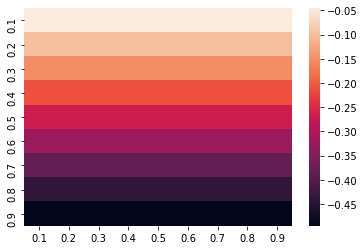

In [51]:
sns.heatmap(D_improve_no_v_partial_change_s_table, annot=False)

# IV. Simulation of various cases

type the following in terminal

jupyter notebook --NotebookApp.iopub_msg_rate_limit=1e10

9.0 Input dataset

In [112]:
# Infection rate 0.02 ~ 0.6
Lambda_set = [0.25, 0.25]

# Exposed to infected rate 1/14 ~ 1/5
Gamma_set = [[1/5, 1/10],
             [0.14, 1/10],
             [1/5, 0.07],
             [0.14, 0.07]]

# Recovery rate for exposed 1/14
Sigma_E_set = [1/14, 1/14]    
# Cured rate for infected 1/20 ~ 1/10
Sigma_I_set = [1/20, 1/10]    
# Death rate (case fatality rate) 2.3% ~ 2.6%
Delta_set = [0.026, 0.023] 

# proportion corresponding to sensitivity clan
# p_i_set = [[0.9, 0.1],[0.8, 0.2],[0.7, 0.3],[0.6, 0.4],[0.5, 0.5]] 
p_i_set = [[0.5, 0.5],[0.4, 0.6],[0.3, 0.7],[0.2, 0.8],[0.1, 0.9]]

# contact rates for different social activity level group
c_j_set = [[25, 15],
           [25, 10],
           [20, 10],
           [20, 5],
           [10, 5]]
# add rational behind of why we do such change
           
# proportion corresponding to contact rates
# p_j_set = [[0.9, 0.1],[0.8, 0.2],[0.7, 0.3],[0.6, 0.4],[0.5, 0.5]]    
p_j_set = [[0.5, 0.5],[0.4, 0.6],[0.3, 0.7],[0.2, 0.8],[0.1, 0.9]]

# Population
T = 100        # Terminal time in week
T_greedy = 1  # number of periods used for greedy


S_0 = 100000    # Initial number of susceptible
R_0 = 0         # Initial number of recovered from E
I_0 = 0         # Initial number of infected 
C_0 = 0         # Initial number of recovered from R
D_0 = 0         # Initial number of Death
# No N_0, it will be calculated in the simulation function

In [113]:
coverage_time = 100
v_epsilon = 1
E_proportion_set = [0.001, 0.002, 0.005, 0.01]

In [114]:
# table summarize all simulation result
# only run this for once
# num of row = num of E situation * num of sensitivity situation
# num of column = 9, 
# E, sensitivity_1, sensitivity_2, 
# proposed % win, proposed average of win, proposed average of lose
# s1c2 % win, s1c2 average of win, s1c2 average of lose
Summary_table_I = np.zeros((len(E_proportion_set) * len(Gamma_set),1 + len(Lambda_set) + 6))
Summary_table_D = np.zeros((len(E_proportion_set) * len(Gamma_set),1 + len(Lambda_set) + 6))

9.2 Simulation given sensitivity and exposed population

Only run the following once

In [37]:
# record max I & total D for all cases regarding %E, s, p_s, c, p_c, strategy
previous_data_I_df = pd.DataFrame({})
previous_data_D_df = pd.DataFrame({})

Update the index for each simulation

In [38]:
# E_proportion_set = [0.001, 0.002, 0.005, 0.01]
E_index = 3 # 0, 1, 2, 3
E_0 = E_proportion_set[E_index] * S_0 
E_index

3

In [39]:
Gamma_index = 3 # 0, 1, 2, 3
Gammas = Gamma_set[Gamma_index] 
Gamma_index

3

In [40]:
# A matrix record all performance data for each simulation
# number of row = number of senstivity proportion * number of contact rate * number of performance evaluation index
# number of column = number of strategy * number of contact rate proportion

num_performance_index = 7 
# (0)Highest I,(1)When 1,(2)Highest I %,(3)When 2,(4)Total D,(5)Fatality rate,(6)Total vaccinated

num_strategy = 6 
# (0)proposed_vaccination,        (1)contact_rate_based_vaccination,
# (2)random_vaccination,          (3)sen_1st_con_2nd_vaccination,
# (4)con_1st_sen_2nd_vaccination, (5)optimal_vaccination

Result_matrix = np.zeros((len(p_i_set)*len(c_j_set)*num_performance_index, num_strategy*len(p_j_set)))

# record each winning and losing w.r.t highest I and total D
winning_situation_I_proposed = []
losing_situation_I_proposed = []
winning_situation_D_proposed = []
losing_situation_D_proposed = []

# record each winning and losing w.r.t highest I and total D
winning_situation_I_s1c2 = []
losing_situation_I_s1c2 = []
winning_situation_D_s1c2 = []
losing_situation_D_s1c2 = []


Run these if no greedy

In [41]:
Max_I_matrix_proposed_no_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))
Death_matrix_proposed_no_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))

Max_I_matrix_s1c2_no_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))
Death_matrix_s1c2_no_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))

Run these if include greedy

In [624]:
# Max_I_matrix_proposed_include_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))
# Death_matrix_proposed_include_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))

# Max_I_matrix_s1c2_include_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))
# Death_matrix_s1c2_include_greedy = np.zeros((len(p_i_set)*len(c_j_set), len(p_j_set)*2))

In [43]:
start_time = time.time()

for sen_prop_i in range(0, len(p_i_set)):
    for con_i in range(0, len(c_j_set)):
        for con_prop_i in range(0, len(p_j_set)):
            
        # 1 simulation for each strategy    
            # 1.1 C * S strategy
            simulation_population_c_and_s = SEIR_simulation(
                terminal_time               = T,
                susceptible_population      = S_0, exposed_population          = E_0,
                recovered_population        = R_0, infected_population         = I_0,
                cured_population            = C_0, deaded_population           = D_0,
        
                contact_rate                = c_j_set[con_i],
                contact_rate_proportion     = p_j_set[con_prop_i],   
        
                infection_rate              = Lambda_set,
                exposed_to_infected_rate    = Gammas,
                recovery_rate_for_exposed   = Sigma_E_set,
                cured_rate_for_infected     = Sigma_I_set,
                death_rate                  = Delta_set,
                sensitivity_proportion      = p_i_set[sen_prop_i],
    
                vaccination_strategy        = proposed_vaccination,
                vaccine_efficacy            = v_epsilon,
                vaccine_coverage_time       = coverage_time,
                total_time_for_greedy       = T_greedy,

                output_presenting_function  = give_performance_table
            )
            
            # 1.2 Contact rate only
            simulation_population_c_only = SEIR_simulation(
                terminal_time               = T,
                susceptible_population      = S_0,
                exposed_population          = E_0,
                recovered_population        = R_0,
                infected_population         = I_0,
                cured_population            = C_0,
                deaded_population           = D_0,
        
                contact_rate                = c_j_set[con_i],
                contact_rate_proportion     = p_j_set[con_prop_i],   
        
                infection_rate              = Lambda_set,
                exposed_to_infected_rate    = Gammas,
                recovery_rate_for_exposed   = Sigma_E_set,
                cured_rate_for_infected     = Sigma_I_set,
                death_rate                  = Delta_set,
                sensitivity_proportion      = p_i_set[sen_prop_i],
    
                vaccination_strategy        = contact_rate_based_vaccination,
                vaccine_efficacy            = v_epsilon,
                vaccine_coverage_time       = coverage_time,
                total_time_for_greedy       = T_greedy,

                output_presenting_function  = give_performance_table
            )
            
            # 1.3 Random vaccination
            simulation_population_random = SEIR_simulation(
                terminal_time               = T,
                susceptible_population      = S_0, exposed_population          = E_0,
                recovered_population        = R_0, infected_population         = I_0,
                cured_population            = C_0, deaded_population           = D_0,
        
                contact_rate                = c_j_set[con_i],
                contact_rate_proportion     = p_j_set[con_prop_i],   
        
                infection_rate              = Lambda_set,
                exposed_to_infected_rate    = Gammas,
                recovery_rate_for_exposed   = Sigma_E_set,
                cured_rate_for_infected     = Sigma_I_set,
                death_rate                  = Delta_set,
                sensitivity_proportion      = p_i_set[sen_prop_i],
    
                vaccination_strategy        = random_vaccination,
                vaccine_efficacy            = v_epsilon,
                vaccine_coverage_time       = coverage_time,
                total_time_for_greedy       = T_greedy,

                output_presenting_function  = give_performance_table
            )
            
            # 1.4 Sen 1st Con 2nd vaccination: the name is WRONG now, not c1s2, but s1c2!
            simulation_population_c1s2 = SEIR_simulation(
                terminal_time               = T,
                susceptible_population      = S_0, exposed_population          = E_0,
                recovered_population        = R_0, infected_population         = I_0,
                cured_population            = C_0, deaded_population           = D_0,
        
                contact_rate                = c_j_set[con_i],
                contact_rate_proportion     = p_j_set[con_prop_i],   
        
                infection_rate              = Lambda_set,
                exposed_to_infected_rate    = Gammas,
                recovery_rate_for_exposed   = Sigma_E_set,
                cured_rate_for_infected     = Sigma_I_set,
                death_rate                  = Delta_set,
                sensitivity_proportion      = p_i_set[sen_prop_i],
    
                vaccination_strategy        = sen_1st_con_2nd_vaccination,
                vaccine_efficacy            = v_epsilon,
                vaccine_coverage_time       = coverage_time,
                total_time_for_greedy       = T_greedy,

                output_presenting_function  = give_performance_table
            )
            
            # 1.5 Con 1st Sen 2nd vaccination
            simulation_population_s1c2 = SEIR_simulation(
                terminal_time               = T,
                susceptible_population      = S_0, exposed_population          = E_0,
                recovered_population        = R_0, infected_population         = I_0,
                cured_population            = C_0, deaded_population           = D_0,
        
                contact_rate                = c_j_set[con_i],
                contact_rate_proportion     = p_j_set[con_prop_i],   
        
                infection_rate              = Lambda_set,
                exposed_to_infected_rate    = Gammas,
                recovery_rate_for_exposed   = Sigma_E_set,
                cured_rate_for_infected     = Sigma_I_set,
                death_rate                  = Delta_set,
                sensitivity_proportion      = p_i_set[sen_prop_i],
    
                vaccination_strategy        = con_1st_sen_2nd_vaccination,
                vaccine_efficacy            = v_epsilon,
                vaccine_coverage_time       = coverage_time,
                total_time_for_greedy       = T_greedy,

                output_presenting_function  = give_performance_table
            )
            
            # 1.6 Greedy approach using optimization of the next single period
#             simulation_population_greedy = SEIR_simulation_greedy(
#                 terminal_time               = T,
#                 susceptible_population      = S_0, exposed_population          = E_0,
#                 recovered_population        = R_0, infected_population         = I_0,
#                 cured_population            = C_0, deaded_population           = D_0,
        
#                 contact_rate                = c_j_set[con_i],
#                 contact_rate_proportion     = p_j_set[con_prop_i],   
        
#                 infection_rate              = Lambda_set,
#                 exposed_to_infected_rate    = Gammas,
#                 recovery_rate_for_exposed   = Sigma_E_set,
#                 cured_rate_for_infected     = Sigma_I_set,
#                 death_rate                  = Delta_set,
#                 sensitivity_proportion      = p_i_set[sen_prop_i],
    
#                 vaccination_strategy        = optimal_vaccination,
#                 vaccine_efficacy            = v_epsilon,
#                 vaccine_coverage_time       = coverage_time,
#                 total_time_for_greedy       = T_greedy,

#                 output_presenting_function  = give_performance_table
#             )
            
            print("----------------------------------------------------------------------------------------------")
            print("exposed proportion = ", E_0/S_0)
            print("senstivity = ", Gammas)
            print("senstivity proportion = ", p_i_set[sen_prop_i])
            print("contact rate = ", c_j_set[con_i])
            print("contact proportion = ", p_j_set[con_prop_i])
            print("----------------------------------------------------------------------------------------------")
        
        # 2 Record the results into Result_matrix
        ## c * s strategy
            Result_matrix[sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index:
                          sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index+num_performance_index,
                         con_prop_i*num_strategy+0] = simulation_population_c_and_s
        ## c only
            Result_matrix[sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index:
                          sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index+num_performance_index,
                         con_prop_i*num_strategy+1] = simulation_population_c_only
        ## random
            Result_matrix[sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index:
                          sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index+num_performance_index,
                         con_prop_i*num_strategy+2] = simulation_population_random
        ## s1c2
            Result_matrix[sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index:
                          sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index+num_performance_index,
                         con_prop_i*num_strategy+3] = simulation_population_s1c2
        ## c1s2
            Result_matrix[sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index:
                          sen_prop_i*len(c_j_set)*num_performance_index+con_i*num_performance_index+num_performance_index,
                         con_prop_i*num_strategy+4] = simulation_population_c1s2
        ## greedy
#             Result_matrix[sen_prop_i*len(p_i_set)*num_performance_index+con_i*num_performance_index:
#                           sen_prop_i*len(p_i_set)*num_performance_index+con_i*num_performance_index+num_performance_index,
#                          con_prop_i*num_strategy+5] = simulation_population_greedy
            
    
    
########################################### if no greedy #################################################

    # 3 Record the Highest infection    
            lowest_max_infection_no_greedy = min(simulation_population_c_and_s[0], simulation_population_c_only[0], 
                                                 simulation_population_random[0], simulation_population_s1c2[0], 
                                                 simulation_population_c1s2[0])
            
    ## 3.1 Record the Highest infection for proposed strategy
            focus_1 = simulation_population_c_and_s[0] 
            
            if focus_1 == lowest_max_infection_no_greedy:
                Max_I_matrix_proposed_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
                second_min_I_1 = min(simulation_population_c_only[0], simulation_population_random[0], 
                                     simulation_population_s1c2[0], simulation_population_c1s2[0])
                Max_I_matrix_proposed_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_I_1 - focus_1)/second_min_I_1
                winning_situation_I_proposed.append((second_min_I_1 - focus_1)/second_min_I_1)
            else:
                Max_I_matrix_proposed_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_1 - lowest_max_infection_no_greedy)/lowest_max_infection_no_greedy
                losing_situation_I_proposed.append((focus_1 - lowest_max_infection_no_greedy)/lowest_max_infection_no_greedy)

    ## 3.2 Record the Highest infection for S1C2 strategy
            focus_2 = simulation_population_s1c2[0]
        
            if focus_2 == lowest_max_infection_no_greedy:
                Max_I_matrix_s1c2_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
                second_min_I_2 = min(simulation_population_c_and_s[0], simulation_population_c_only[0], 
                                   simulation_population_random[0], simulation_population_c1s2[0])
                Max_I_matrix_s1c2_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_I_2 - focus_2)/second_min_I_2
                winning_situation_I_s1c2.append((second_min_I_2 - focus_2)/second_min_I_2)
            else:
                Max_I_matrix_s1c2_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_2 - lowest_max_infection_no_greedy)/lowest_max_infection_no_greedy
                losing_situation_I_s1c2.append((focus_2 - lowest_max_infection_no_greedy)/lowest_max_infection_no_greedy)

    # 4 Record total death

            lowest_total_death_no_greedy = min(simulation_population_c_and_s[4], simulation_population_c_only[4], simulation_population_random[4],
                               simulation_population_s1c2[4], simulation_population_c1s2[4])
            
    ## 4.1 Record total death for proposed strategy
            focus_3 = simulation_population_c_and_s[4]
        
            if focus_3 == lowest_total_death_no_greedy:
                Death_matrix_proposed_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
                second_min_death_3 = min(simulation_population_c_only[4], simulation_population_random[4], 
                                       simulation_population_s1c2[4], simulation_population_c1s2[4])
                Death_matrix_proposed_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_death_3 - focus_3)/second_min_death_3
                winning_situation_D_proposed.append((second_min_death_3 - focus_3)/second_min_death_3)
            else:
                Death_matrix_proposed_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_3 - lowest_total_death_no_greedy)/lowest_total_death_no_greedy
                losing_situation_D_proposed.append((focus_3 - lowest_total_death_no_greedy)/lowest_total_death_no_greedy)

    # 4.2 Record total death for s1c2 strategy
            focus_4 = simulation_population_s1c2[4]
        
            if focus_4 == lowest_total_death_no_greedy:
                Death_matrix_s1c2_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
                second_min_death = min(simulation_population_c_and_s[4], simulation_population_c_only[4], 
                                       simulation_population_random[4], simulation_population_c1s2[4])
                Death_matrix_s1c2_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_death - focus_4)/second_min_death
                winning_situation_D_s1c2.append((second_min_death - focus_4)/second_min_death)
            else:
                Death_matrix_s1c2_no_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_4 - lowest_total_death_no_greedy)/lowest_total_death_no_greedy
                losing_situation_D_s1c2.append((focus_4 - lowest_total_death_no_greedy)/lowest_total_death_no_greedy)
                         
    # 5 Record max I and total D after 1 simulation for each strategy 
    
            data_set_I = [simulation_population_c_and_s[0], simulation_population_c_only[0],
                          simulation_population_random[0],  simulation_population_s1c2[0],
                          simulation_population_c1s2[0]]
            data_collection_I = {'Max I':  data_set_I, 
                                 'Strategy': (['C*S'] + ['C only'] + ['Random'] + ['S1C2'] + ['C1S2']),
                                 'Contact':     ([(c_j_set[con_i][0],         c_j_set[con_i][1])        ] * 5),
                                 'C_p':         ([(p_j_set[con_prop_i][0],    p_j_set[con_prop_i][1])   ] * 5),
                                 'Sensitivity': ([(Gamma_set[Gamma_index][0], Gamma_set[Gamma_index][1])] * 5),
                                 'S_p':         ([(p_i_set[sen_prop_i][0],    p_i_set[sen_prop_i][1])   ] * 5),
                                 '%E':          ([E_proportion_set[E_index]                             ] * 5) }
            data_I_df = pd.DataFrame(data_collection_I)
            frames_I = [previous_data_I_df, data_I_df]
            merged_data_I_df = pd.concat(frames_I)
            previous_data_I_df = merged_data_I_df
            
            
            data_set_D = [simulation_population_c_and_s[4], simulation_population_c_only[4],
                          simulation_population_random[4],  simulation_population_s1c2[4],
                          simulation_population_c1s2[4]]
            data_collection_D = {'Death': data_set_D, 
                                 'Strategy': (['C*S'] + ['C only'] + ['Random'] + ['S1C2'] + ['C1S2']),
                                 'Contact':     ([(c_j_set[con_i][0],         c_j_set[con_i][1])        ] * 5),
                                 'C_p':         ([(p_j_set[con_prop_i][0],    p_j_set[con_prop_i][1])   ] * 5),
                                 'Sensitivity': ([(Gamma_set[Gamma_index][0], Gamma_set[Gamma_index][1])] * 5),
                                 'S_p':         ([(p_i_set[sen_prop_i][0],    p_i_set[sen_prop_i][1])   ] * 5),
                                 '%E':          ([E_proportion_set[E_index]                             ] * 5) }
            data_D_df = pd.DataFrame(data_collection_D)
            frames_D = [previous_data_D_df, data_D_df]
            merged_data_D_df = pd.concat(frames_D)
            previous_data_D_df = merged_data_D_df
    
########################################### if no greedy #################################################


########################################### if include greedy #################################################

#     # 3 Record the Highest infection    
#             lowest_max_infection_include_greedy = min(simulation_population_c_and_s[0], simulation_population_c_only[0], 
#                                                  simulation_population_random[0], simulation_population_s1c2[0], 
#                                                  simulation_population_c1s2[0], simulation_population_greedy[0])
            
#     ## 3.1 Record the Highest infection for proposed strategy
#             focus_1 = simulation_population_c_and_s[0] 
            
#             if focus_1 == lowest_max_infection_include_greedy:
#                 Max_I_matrix_proposed_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
#                 second_min_I_1 = min(simulation_population_c_only[0], simulation_population_random[0], 
#                                      simulation_population_s1c2[0], simulation_population_c1s2[0],
#                                      simulation_population_greedy[0])
#                 Max_I_matrix_proposed_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_I_1 - focus_1)/second_min_I_1
#                 winning_situation_I_proposed.append((second_min_I_1 - focus_1)/second_min_I_1)
#             else:
#                 Max_I_matrix_proposed_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_1 - lowest_max_infection_include_greedy)/lowest_max_infection_include_greedy
#                 losing_situation_I_proposed.append((focus_1 - lowest_max_infection_include_greedy)/lowest_max_infection_include_greedy)


#     ## 3.2 Record the Highest infection for S1C2 strategy
#             focus_2 = simulation_population_s1c2[0]
        
#             if focus_2 == lowest_max_infection_include_greedy:
#                 Max_I_matrix_s1c2_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
#                 second_min_I_2 = min(simulation_population_c_and_s[0], simulation_population_c_only[0], 
#                                    simulation_population_random[0], simulation_population_c1s2[0],
#                                     simulation_population_greedy[0])
#                 Max_I_matrix_s1c2_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_I_2 - focus_2)/second_min_I_2
#                 winning_situation_I_s1c2.append((second_min_I_2 - focus_2)/second_min_I_2)
#             else:
#                 Max_I_matrix_s1c2_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_2 - lowest_max_infection_include_greedy)/lowest_max_infection_include_greedy
#                 losing_situation_I_s1c2.append((focus_2 - lowest_max_infection_include_greedy)/lowest_max_infection_include_greedy)
    

#     # 4 Record total death
        
#             lowest_total_death_include_greedy = min(simulation_population_c_and_s[4], simulation_population_c_only[4], simulation_population_random[4],
#                                simulation_population_s1c2[4], simulation_population_c1s2[4], simulation_population_greedy[4])
    
#     ## 4.1 Record total death for proposed strategy
#             focus_3 = simulation_population_c_and_s[4]
        
#             if focus_3 == lowest_total_death_include_greedy:
#                 Death_matrix_proposed_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
#                 second_min_death_3 = min(simulation_population_c_only[4], simulation_population_random[4], 
#                                        simulation_population_s1c2[4], simulation_population_c1s2[4],
#                                         simulation_population_greedy[4])
#                 Death_matrix_proposed_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_death_3 - focus_3)/second_min_death_3
#                 winning_situation_D_proposed.append((second_min_death_3 - focus_3)/second_min_death_3)
#             else:
#                 Death_matrix_proposed_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_3 - lowest_total_death_include_greedy)/lowest_total_death_include_greedy
#                 losing_situation_D_proposed.append((focus_3 - lowest_total_death_include_greedy)/lowest_total_death_include_greedy)
    

#     # 4.2 Record total death for s1c2 strategy
#             focus_4 = simulation_population_s1c2[4]
        
#             if focus_4 == lowest_total_death_include_greedy:
#                 Death_matrix_s1c2_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2] = 1
#                 second_min_death = min(simulation_population_c_and_s[4], simulation_population_c_only[4], 
#                                        simulation_population_random[4], simulation_population_c1s2[4],
#                                       simulation_population_greedy[4])
#                 Death_matrix_s1c2_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (second_min_death - focus_4)/second_min_death
#                 winning_situation_D_s1c2.append((second_min_death - focus_4)/second_min_death)
#             else:
#                 Death_matrix_s1c2_include_greedy[sen_prop_i*len(c_j_set)+con_i,con_prop_i*2+1] = (focus_4 - lowest_total_death_include_greedy)/lowest_total_death_include_greedy
#                 losing_situation_D_s1c2.append((focus_4 - lowest_total_death_include_greedy)/lowest_total_death_include_greedy)
                
    

#     # 5 Record max I and total D after 1 simulation for each strategy 
    
#             data_set_I = [simulation_population_c_and_s[0], simulation_population_c_only[0],
#                           simulation_population_random[0],  simulation_population_s1c2[0],
#                           simulation_population_c1s2[0],    simulation_population_greedy[0]]
#             data_collection_I = {'Max I':  data_set_I, 
#                                  'Strategy': (['C*S'] + ['C only'] + ['Random'] + ['S1C2'] + ['C1S2'] + ['Greedy']),
#                                  'Contact':     ([(c_j_set[con_i][0],         c_j_set[con_i][1])        ] * 6),
#                                  'C_p':         ([(p_j_set[con_prop_i][0],    p_j_set[con_prop_i][1])   ] * 6),
#                                  'Sensitivity': ([(Gamma_set[Gamma_index][0], Gamma_set[Gamma_index][1])] * 6),
#                                  'S_p':         ([(p_i_set[sen_prop_i][0],    p_i_set[sen_prop_i][1])   ] * 6),
#                                  '%E':          ([E_proportion_set[E_index]                             ] * 6) }
#             data_I_df = pd.DataFrame(data_collection_I)
#             frames_I = [previous_data_I_df, data_I_df]
#             merged_data_I_df = pd.concat(frames_I)
#             previous_data_I_df = merged_data_I_df
            
            
#             data_set_D = [simulation_population_c_and_s[4], simulation_population_c_only[4],
#                           simulation_population_random[4],  simulation_population_s1c2[4],
#                           simulation_population_c1s2[4],    simulation_population_greedy[0]]
#             data_collection_D = {'Death': data_set_D, 
#                                  'Strategy': (['C*S'] + ['C only'] + ['Random'] + ['S1C2'] + ['C1S2'] + ['Greedy']),
#                                  'Contact':     ([(c_j_set[con_i][0],         c_j_set[con_i][1])        ] * 6),
#                                  'C_p':         ([(p_j_set[con_prop_i][0],    p_j_set[con_prop_i][1])   ] * 6),
#                                  'Sensitivity': ([(Gamma_set[Gamma_index][0], Gamma_set[Gamma_index][1])] * 6),
#                                  'S_p':         ([(p_i_set[sen_prop_i][0],    p_i_set[sen_prop_i][1])   ] * 6),
#                                  '%E':          ([E_proportion_set[E_index]                             ] * 6) }
#             data_D_df = pd.DataFrame(data_collection_D)
#             frames_D = [previous_data_D_df, data_D_df]
#             merged_data_D_df = pd.concat(frames_D)
#             previous_data_D_df = merged_data_D_df
            
########################################### if include greedy #################################################


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.5, 0.5]
contact rate =  [25, 15]
contact proportion =  [0.5, 0.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.5, 0.5]
contact rate =  [25, 15]
contact proportion =  [0.4, 0.6]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.5, 0.5]
contact rate =  [25, 15]
contact proportion =  [0.3, 0.7]
---------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.4, 0.6]
contact rate =  [25, 15]
contact proportion =  [0.5, 0.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.4, 0.6]
contact rate =  [25, 15]
contact proportion =  [0.4, 0.6]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.4, 0.6]
contact rate =  [25, 15]
contact proportion =  [0.3, 0.7]
---------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.3, 0.7]
contact rate =  [25, 15]
contact proportion =  [0.5, 0.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.3, 0.7]
contact rate =  [25, 15]
contact proportion =  [0.4, 0.6]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.3, 0.7]
contact rate =  [25, 15]
contact proportion =  [0.3, 0.7]
---------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.2, 0.8]
contact rate =  [25, 15]
contact proportion =  [0.5, 0.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.2, 0.8]
contact rate =  [25, 15]
contact proportion =  [0.4, 0.6]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.2, 0.8]
contact rate =  [25, 15]
contact proportion =  [0.3, 0.7]
---------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.1, 0.9]
contact rate =  [25, 15]
contact proportion =  [0.5, 0.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.1, 0.9]
contact rate =  [25, 15]
contact proportion =  [0.4, 0.6]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
exposed proportion =  0.01
senstivity =  [0.14, 0.07]
senstivity proportion =  [0.1, 0.9]
contact rate =  [25, 15]
contact proportion =  [0.3, 0.7]
---------------------------------------------------------------------------------

In [626]:
# for i = 0, ..., 15, change the row index after each simulation
i_index = len(E_proportion_set) * E_index + Gamma_index
E_index, Gamma_index, i_index

(3, 3, 15)

In [627]:
len(winning_situation_I_proposed),len(winning_situation_I_s1c2),len(winning_situation_D_proposed),len(winning_situation_D_s1c2)

(89, 37, 75, 0)

In [628]:
##################### record winning rate w.r.t. max I
Summary_table_I[i_index,0] = E_0/S_0

for i in range(0,len(Lambda_set)):
    Summary_table_I[i_index,i+1] = Gammas[i]

##### winning rate C*S ##### 
Summary_table_I[i_index,len(Lambda_set)+1] = len(winning_situation_I_proposed)/(len(winning_situation_I_proposed) + len(losing_situation_I_proposed)) 

##### winning average C*S
if len(winning_situation_I_proposed) == 0:
    Summary_table_I[i_index,len(Lambda_set)+2] = 0
else:
    Summary_table_I[i_index,len(Lambda_set)+2] = sum(winning_situation_I_proposed)/len(winning_situation_I_proposed)

##### losing average C*S
if len(losing_situation_I_proposed) == 0:
    Summary_table_I[i_index,len(Lambda_set)+3] = 0
else:
    Summary_table_I[i_index,len(Lambda_set)+3] = sum(losing_situation_I_proposed)/len(losing_situation_I_proposed)

##### winning rate S1C2 #####
Summary_table_I[i_index,len(Lambda_set)+4] = len(winning_situation_I_s1c2)/(len(winning_situation_I_s1c2) + len(losing_situation_I_s1c2)) 

##### winning average S1C2
if len(winning_situation_I_s1c2) == 0:
    Summary_table_I[i_index,len(Lambda_set)+5] = 0
else:
    Summary_table_I[i_index,len(Lambda_set)+5] = sum(winning_situation_I_s1c2)/len(winning_situation_I_s1c2)

##### losing average S1C2
if len(losing_situation_I_s1c2) == 0:
    Summary_table_I[i_index,len(Lambda_set)+6] = 0
else:
    Summary_table_I[i_index,len(Lambda_set)+6] = sum(losing_situation_I_s1c2)/len(losing_situation_I_s1c2)


##################### record winning rate w.r.t. Death
Summary_table_D[i_index,0] = E_0/S_0

for i in range(0,len(Lambda_set)):
    Summary_table_D[i_index,i+1] = Gammas[i]
    
##### winning rate C*S #####
Summary_table_D[i_index,len(Lambda_set)+1] = len(winning_situation_D_proposed)/(len(winning_situation_D_proposed) + len(losing_situation_D_proposed))

##### winning average C*S 
if len(winning_situation_D_proposed) == 0:
    Summary_table_D[i_index,len(Lambda_set)+2] = 0 # in case no winning with lenght zero
else:
    Summary_table_D[i_index,len(Lambda_set)+2] = sum(winning_situation_D_proposed)/len(winning_situation_D_proposed)

##### losing average C*S 
if len(losing_situation_D_proposed) == 0:
    Summary_table_D[i_index,len(Lambda_set)+3] = 0
else:
    Summary_table_D[i_index,len(Lambda_set)+3] = sum(losing_situation_D_proposed)/len(losing_situation_D_proposed)

##### winning rate S1C2 #####
Summary_table_D[i_index,len(Lambda_set)+4] = len(winning_situation_D_s1c2)/(len(winning_situation_D_s1c2) + len(losing_situation_D_s1c2))

##### winning average S1C2
if len(winning_situation_D_s1c2) == 0:
    Summary_table_D[i_index,len(Lambda_set)+5] = 0
else:
    Summary_table_D[i_index,len(Lambda_set)+5] = sum(winning_situation_D_s1c2)/len(winning_situation_D_s1c2)

##### losing average S1C2
if len(losing_situation_D_s1c2) == 0:
    Summary_table_D[i_index,len(Lambda_set)+6] = 0
else:
    Summary_table_D[i_index,len(Lambda_set)+6] = sum(losing_situation_D_s1c2)/len(losing_situation_D_s1c2)

In [629]:
# strategy C*S, S1C2
Summary_table_I[0:i_index+1,3],Summary_table_I[0:i_index+1,6]

(array([0.712, 0.24 , 0.848, 0.696, 0.704, 0.256, 0.848, 0.696, 0.72 ,
        0.304, 0.856, 0.712, 0.72 , 0.32 , 0.848, 0.712]),
 array([0.248, 0.24 , 0.224, 0.224, 0.248, 0.256, 0.224, 0.24 , 0.288,
        0.304, 0.256, 0.28 , 0.296, 0.32 , 0.288, 0.296]))

In [630]:
Summary_table_D[0:i_index+1,3],Summary_table_D[0:i_index+1,6]

(array([0.592, 0.   , 0.784, 0.6  , 0.6  , 0.   , 0.784, 0.6  , 0.6  ,
        0.   , 0.784, 0.6  , 0.592, 0.   , 0.776, 0.6  ]),
 array([0.024, 0.   , 0.032, 0.   , 0.032, 0.   , 0.032, 0.   , 0.032,
        0.   , 0.032, 0.   , 0.04 , 0.   , 0.04 , 0.   ]))

In [631]:
E_0/S_0, Gammas # change the name of excel

(0.01, [0.14, 0.07])

Change the name of excel

In [632]:
Result_matrix_df = pd.DataFrame(Result_matrix)

Max_I_matrix_proposed_no_greedy_df = pd.DataFrame(Max_I_matrix_proposed_no_greedy)
Death_matrix_proposed_no_greedy_df = pd.DataFrame(Death_matrix_proposed_no_greedy)
Max_I_matrix_s1c2_no_greedy_df = pd.DataFrame(Max_I_matrix_s1c2_no_greedy)
Death_matrix_s1c2_no_greedy_df = pd.DataFrame(Death_matrix_s1c2_no_greedy)

writer = pd.ExcelWriter(f"E = {E_0/S_0} sen = {Gammas}.xlsx")

Result_matrix_df.to_excel(writer, sheet_name = "Performance", index = False)
Max_I_matrix_proposed_no_greedy_df.to_excel(writer, sheet_name = "I proposed", index = False)
Max_I_matrix_s1c2_no_greedy_df.to_excel(writer, sheet_name = "I s1c2", index = False)
Death_matrix_proposed_no_greedy_df.to_excel(writer, sheet_name = "D proposed", index = False)
Death_matrix_s1c2_no_greedy_df.to_excel(writer, sheet_name = "D s1c2", index = False)

writer.save()


# Summary of all performance 

Run this after finishing all simulations

In [633]:
Summary_table_I_df = pd.DataFrame(Summary_table_I)
Summary_table_D_df = pd.DataFrame(Summary_table_D)

writer2 = pd.ExcelWriter("Summary.xlsx")

Summary_table_I_df.to_excel(writer2, sheet_name = "I", index = False)  
Summary_table_D_df.to_excel(writer2, sheet_name = "D", index = False) 

writer2.save()

# Display performance for all situations in tables

Run after all %E, sensitivity, contact, proportion

Save the above tables for 4 p_s p_c combinations

(1) Record merged_data_I_df and merged_data_D_df for high p_s and high p_c

In [246]:
data_I_df_high_ps_high_pc = merged_data_I_df
data_D_df_high_ps_high_pc = merged_data_D_df

writer3 = pd.ExcelWriter("Table of all situations, No greedy, p_s high, p_c high.xlsx")
data_I_df_high_ps_high_pc.to_excel(writer3, sheet_name = "I", index = False)  
data_D_df_high_ps_high_pc.to_excel(writer3, sheet_name = "D", index = False) 
writer3.save()

(2) Record merged_data_I_df and merged_data_D_df for high p_s and low p_c

In [451]:
data_I_df_high_ps_low_pc = merged_data_I_df
data_D_df_high_ps_low_pc = merged_data_D_df

writer4 = pd.ExcelWriter("Table of all situations, No greedy, p_s high, p_c low.xlsx")
data_I_df_high_ps_low_pc.to_excel(writer4, sheet_name = "I", index = False)  
data_D_df_high_ps_low_pc.to_excel(writer4, sheet_name = "D", index = False) 
writer4.save()

(3) Record merged_data_I_df and merged_data_D_df for LOW p_s and HIGH p_c

In [656]:
data_I_df_low_ps_high_pc = merged_data_I_df
data_D_df_low_ps_high_pc = merged_data_D_df

writer5 = pd.ExcelWriter("Table of all situations, No greedy, p_s low, p_c high.xlsx")
data_I_df_low_ps_high_pc.to_excel(writer5, sheet_name = "I", index = False)  
data_D_df_low_ps_high_pc.to_excel(writer5, sheet_name = "D", index = False) 
writer5.save()

(4) Record merged_data_I_df and merged_data_D_df for low p_c and low p_s

In [858]:
data_I_df_low_ps_low_pc = merged_data_I_df
data_D_df_low_ps_low_pc = merged_data_D_df

writer6 = pd.ExcelWriter("Table of all situations, No greedy, p_s low, p_c low.xlsx")
data_I_df_low_ps_low_pc.to_excel(writer6, sheet_name = "I", index = False)  
data_D_df_low_ps_low_pc.to_excel(writer6, sheet_name = "D", index = False) 
writer6.save()

Show the table of all Max I and Death

In [859]:
merged_data_I_df

,Max I,Strategy,Contact,C_p,Sensitivity,S_p,%E
0,34194.158290,C*S,"(25, 15)","(0.5, 0.5)","(0.2, 0.1)","(0.5, 0.5)",0.001
1,34963.415729,C only,"(25, 15)","(0.5, 0.5)","(0.2, 0.1)","(0.5, 0.5)",0.001
2,34954.948183,Random,"(25, 15)","(0.5, 0.5)","(0.2, 0.1)","(0.5, 0.5)",0.001
3,34194.158290,S1C2,"(25, 15)","(0.5, 0.5)","(0.2, 0.1)","(0.5, 0.5)",0.001
4,34194.158290,C1S2,"(25, 15)","(0.5, 0.5)","(0.2, 0.1)","(0.5, 0.5)",0.001
...,...,...,...,...,...,...,...
1,20355.377438,C only,"(10, 5)","(0.1, 0.9)","(0.14, 0.07)","(0.1, 0.9)",0.010
2,20384.985673,Random,"(10, 5)","(0.1, 0.9)","(0.14, 0.07)","(0.1, 0.9)",0.010
3,19078.456125,S1C2,"(10, 5)","(0.1, 0.9)","(0.14, 0.07)","(0.1, 0.9)",0.010
4,20171.734083,C1S2,"(10, 5)","(0.1, 0.9)","(0.14, 0.07)","(0.1, 0.9)",0.010


In [558]:
merged_data_D_df

,Death,Strategy,Contact,C_p,Sensitivity,S_p,%E
0,20817.791055,C*S,"(25, 15)","(0.9, 0.1)","(0.2, 0.1)","(0.9, 0.1)",0.001
1,20998.840335,C only,"(25, 15)","(0.9, 0.1)","(0.2, 0.1)","(0.9, 0.1)",0.001
2,20918.238903,Random,"(25, 15)","(0.9, 0.1)","(0.2, 0.1)","(0.9, 0.1)",0.001
3,20877.663087,S1C2,"(25, 15)","(0.9, 0.1)","(0.2, 0.1)","(0.9, 0.1)",0.001
4,20933.102239,C1S2,"(25, 15)","(0.9, 0.1)","(0.2, 0.1)","(0.9, 0.1)",0.001
...,...,...,...,...,...,...,...
0,13166.971885,C*S,"(10, 5)","(0.5, 0.5)","(0.14, 0.07)","(0.5, 0.5)",0.010
1,13777.943223,C only,"(10, 5)","(0.5, 0.5)","(0.14, 0.07)","(0.5, 0.5)",0.010
2,13731.448429,Random,"(10, 5)","(0.5, 0.5)","(0.14, 0.07)","(0.5, 0.5)",0.010
3,13154.101998,S1C2,"(10, 5)","(0.5, 0.5)","(0.14, 0.07)","(0.5, 0.5)",0.010
